In [1]:
from pylab import *
import h5py
import shutil
import tempfile
import sys
import caffe
import os
import sys
from scipy import stats
from sklearn.metrics import mean_squared_error as mse
import pickle
import subprocess as sub
from collections import defaultdict
import itertools
import pickle
import time
import datetime
import matplotlib.pyplot as plt

#plt.style.use('ggplot')
%matplotlib inline
# Take care with the paths -defaults ones from protobuf are not correct. Need to change snapshot and train / test data paths 

caffe_root = '/home/nikhil/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/NN_MC/'
os.chdir(baseline_dir)

caffe.set_device(3)
caffe.set_mode_gpu()

#Useful resources:
#http://stackoverflow.com/questions/33140000/how-to-feed-caffe-multi-label-data-in-hdf5-format
#http://nbviewer.jupyter.org/github/BVLC/caffe/blob/master/examples/00-classification.ipynb
#http://nbviewer.jupyter.org/github/BVLC/caffe/blob/master/examples/01-learning-lenet.ipynb

In [2]:
import tables as tb
from sklearn import preprocessing
def load_data(data_path, input_node, preproc):
    data = tb.open_file(data_path, 'r')
    X_raw = data.get_node('/' + input_node)[:]
    if preproc == 'scale':
        X = preprocessing.scale(X_raw)
    elif preproc == 'norm_max':
        X = preprocessing.normalize(X_raw, norm='max')
    elif preproc == 'norm_l2':
        X = preprocessing.normalize(X_raw, norm='l2')
    else:
        X = X_raw
    data.close()
    return X

# Some defs to load data and extract encodings from trained net
import collections
def extract_features(net_file, model_file, data_path, input_nodes, batch_size, encoding_layer, weight_layers, multi_task):
    os.chdir(os.path.dirname(net_file))
    net = caffe.Net(net_file, model_file, caffe.TEST)        
    
    #print net.blobs.items()[0]
    #print net.blobs.items()[1]
    
    #Get weights    
    layer_list = weight_layers
    wt_dict = collections.OrderedDict()
    for l, name in enumerate(net._layer_names):            
        if name in layer_list:
            wt_dict[name] = net.layers[l].blobs[0].data
    
    BATCH_SIZE = batch_size        
    N = load_data(data_path, input_nodes[0],'no_preproc').shape[0]
    iters = int(np.ceil(N / float(BATCH_SIZE)))

    if not multi_task:
        code_layer = net.blobs[encoding_layer]
        out_shape = code_layer.data.shape    
        X_out = np.zeros(shape=(N, out_shape[1]))        
        #print 'X_out.shape: {}'.format(X_out.shape)
        
    else:
        code_layer_adas13 = net.blobs[encoding_layer + '_ADAS13']
        code_layer_mmse = net.blobs[encoding_layer + '_MMSE']
        out_shape = code_layer_adas13.data.shape 
        X_out_adas13 = np.zeros(shape=(N, out_shape[1]))
        X_out_mmse = np.zeros(shape=(N, out_shape[1]))
        #print 'X_out.shape: {},{}'.format(X_out_adas13.shape,X_out_mmse.shape)
    
    X_list = []
    data_layers = []
    for i, input_node in enumerate(input_nodes):
        X_list.append(load_data(data_path, input_node,'no_preproc'))
        #print net.blobs[input_node].shape
        
        data_layers.append(net.blobs[input_node])    
        #print 'X_list shape: {}'.format(X_list[i].shape)
        #print 'data_layers shape: {}'.format(data_layers[i].data.shape)
        data_layers[i].reshape(BATCH_SIZE, X_list[i].shape[1]) # TODO: only works for 2-D inputs
        #print 'data_layers shape: {}'.format(data_layers[i].data.shape)
    
     
    net.reshape()            
    #print 'Extracting features from data...'
    
    for i in xrange(iters):
        #print '.',
        for m, X in enumerate(X_list):
            X_b = X[i * BATCH_SIZE: (i+1) * BATCH_SIZE,:]
            batch_sampx = X_b.shape[0]
            # Pad last batch with zeros
            if X_b.shape[0] < BATCH_SIZE:
                #print 'Zero-padding last batch with {} rows'.format(BATCH_SIZE-X_b.shape[0])
                X_b = np.vstack((X_b,np.zeros((BATCH_SIZE-X_b.shape[0],X_b.shape[1]))))                       
            
            data_layers[m].data[...] = X_b
            
        net.forward()
        
        if not multi_task:
            X_out[i * BATCH_SIZE: min((i+1) * BATCH_SIZE, N)] = code_layer.data[0:batch_sampx,:].copy()
        else:
            X_out_adas13[i * BATCH_SIZE: min((i+1) * BATCH_SIZE, N)] = code_layer_adas13.data[0:batch_sampx,:].copy()
            X_out_mmse[i * BATCH_SIZE: min((i+1) * BATCH_SIZE, N)] = code_layer_mmse.data[0:batch_sampx,:].copy()
            X_out = {'adas13':X_out_adas13,'mmse':X_out_mmse}
    return {'X_out':X_out, 'wt_dict':wt_dict}

In [3]:
from caffe import layers as L
from caffe import params as P

def adninet_ff_HC(hdf5, batch_size, node_sizes, dr, lr, tr, Clinical_Scale):
    n = caffe.NetSpec()
    
    #------- Input -----------------#
    if Clinical_Scale == 'ADAS13':
        n.X_L_HC,n.X_R_HC,n.adas  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=3) #orig
    elif Clinical_Scale == 'MMSE':
        n.X_L_HC,n.X_R_HC,n.mmse  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=3) #orig
    elif Clinical_Scale == 'BOTH':
        n.X_L_HC,n.X_R_HC,n.adas,n.mmse  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=4) #orig
    else:
        print 'Unknow Clinical Scale: {}'.format(Clinical_Scale)
        
    #-------Hidden Layers-----------#
    #ff layers Left HC
    #n.L_ff1 = L.InnerProduct(n.X_L_HC, num_output=node_sizes['L_ff1'], param=dict(lr_mult=2), weight_filler=dict(type='gaussian',std=0.008))
    n.L_ff1 = L.InnerProduct(n.X_L_HC, num_output=node_sizes['HC_L_ff'], param=dict(lr_mult=lr['HC']), weight_filler=dict(type='xavier'))
    n.NLinEnL1 = L.ReLU(n.L_ff1, in_place=True)
    n.dropL1 = L.Dropout(n.L_ff1, in_place=True,dropout_param=dict(dropout_ratio=dr['HC']))
    
    #ff layers Right HC
    #n.R_ff1 = L.InnerProduct(n.X_R_HC, num_output=node_sizes['R_ff1'], param=dict(lr_mult=2), weight_filler=dict(type='gaussian',std=0.008))
    n.R_ff1 = L.InnerProduct(n.X_R_HC, num_output=node_sizes['HC_R_ff'], param=dict(lr_mult=lr['HC']), weight_filler=dict(type='xavier'))
    n.NLinEnR1 = L.ReLU(n.R_ff1, in_place=True)
    n.dropR1 = L.Dropout(n.R_ff1, in_place=True,dropout_param=dict(dropout_ratio=dr['HC']))
    
    #ff layers Concat
    n.concat = L.Concat(n.L_ff1,n.R_ff1, concat_param=dict(axis=1))
    n.ff3 = L.InnerProduct(n.concat, num_output=node_sizes['COMB_ff'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
    n.NLinEn3 = L.ReLU(n.ff3, in_place=True)
  
    #Task layers    
    if Clinical_Scale == 'BOTH': ## Split layers (multitask)
        n.ff1_ADAS13 = L.InnerProduct(n.ff3, num_output=node_sizes['ADAS_ff'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
        n.NLin1ADAS13 = L.ReLU(n.ff1_ADAS13, in_place=True)
        
        n.ff1_MMSE = L.InnerProduct(n.ff3, num_output=node_sizes['MMSE_ff'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
        n.NLin1MMSE = L.ReLU(n.ff1_MMSE, in_place=True)
    else:
        #n.ff4 = L.InnerProduct(n.ff3, num_output=node_sizes['ff4'], param=dict(lr_mult=1), weight_filler=dict(type='gaussian',std=0.177))
        n.ff4 = L.InnerProduct(n.ff3, num_output=node_sizes['COMB_ff'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
        n.NLinEn4 = L.ReLU(n.ff4, in_place=True)
    
    #--------Output--------------#
    #n.output = L.InnerProduct(n.ff4, num_output=1, weight_filler=dict(type='gaussian',std=0.177))          
    if Clinical_Scale == 'ADAS13':
        n.output = L.InnerProduct(n.ff3, num_output=1, weight_filler=dict(type='xavier'))
        n.loss = L.EuclideanLoss(n.output, n.adas)            
    elif Clinical_Scale == 'MMSE':
        n.output = L.InnerProduct(n.ff3, num_output=1, weight_filler=dict(type='xavier'))
        n.loss = L.EuclideanLoss(n.output, n.mmse)
    elif Clinical_Scale == 'BOTH':
        n.output_ADAS13 = L.InnerProduct(n.ff1_ADAS13, num_output=1, weight_filler=dict(type='xavier'))
        n.ADAS13_loss = L.EuclideanLoss(n.output_ADAS13, n.adas,loss_weight=tr['ADAS'])          
        n.output_MMSE = L.InnerProduct(n.ff1_MMSE, num_output=1, weight_filler=dict(type='xavier'))
        n.MMSE_loss = L.EuclideanLoss(n.output_MMSE, n.mmse,loss_weight=tr['MMSE'])  
    else:
        print 'Unknow Clinical Scale: {}'.format(Clinical_Scale)
    
    return n.to_proto()

def adninet_ff_CT(hdf5, batch_size, node_sizes, dr, lr, tr, Clinical_Scale):
    n = caffe.NetSpec()
    
    #------- Input -----------------#
    if Clinical_Scale == 'ADAS13':
        n.X_CT_SpecCluster_dyn,n.adas  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=2) #orig
    elif Clinical_Scale == 'MMSE':
        n.X_CT_SpecCluster_dyn,n.mmse  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=2) #orig
    elif Clinical_Scale == 'BOTH':
        n.X_CT_SpecCluster_dyn,n.adas,n.mmse  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=3) #orig
    else:
        print 'Unknow Clinical Scale: {}'.format(Clinical_Scale)
        
    #-------Hidden Layers-----------#
    n.ff1 = L.InnerProduct(n.X_CT_SpecCluster_dyn, num_output=node_sizes['CT_ff'], param=dict(lr_mult=lr['CT']), weight_filler=dict(type='xavier'))
    n.NLinEnL1 = L.ReLU(n.ff1, in_place=True)
    n.dropL1 = L.Dropout(n.ff1, in_place=True,dropout_param=dict(dropout_ratio=dr['CT'])) 

    #Task Layers
    if Clinical_Scale == 'BOTH': ## Split layers (multitask)
        n.ff1_ADAS13 = L.InnerProduct(n.ff1, num_output=node_sizes['ADAS_ff'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
        n.NLin1ADAS13 = L.ReLU(n.ff1_ADAS13, in_place=True)
        
        n.ff1_MMSE = L.InnerProduct(n.ff1, num_output=node_sizes['MMSE_ff'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
        n.NLin1MMSE = L.ReLU(n.ff1_MMSE, in_place=True)        
    else:
        n.ff2 = L.InnerProduct(n.ff1, num_output=node_sizes['CT_ff'], param=dict(lr_mult=lr['CT']), weight_filler=dict(type='xavier'))
        n.NLinEnL2 = L.ReLU(n.ff2, in_place=True)
        n.dropL2 = L.Dropout(n.ff2, in_place=True,dropout_param=dict(dropout_ratio=dr['CT']))
    
    #--------Output--------------#
    #n.output = L.InnerProduct(n.ff4, num_output=1, weight_filler=dict(type='gaussian',std=0.177))          
    if Clinical_Scale == 'ADAS13':
        n.output = L.InnerProduct(n.ff2, num_output=1, weight_filler=dict(type='xavier'))
        n.loss = L.EuclideanLoss(n.output, n.adas)            
    elif Clinical_Scale == 'MMSE':
        n.output = L.InnerProduct(n.ff2, num_output=1, weight_filler=dict(type='xavier'))
        n.loss = L.EuclideanLoss(n.output, n.mmse)
    elif Clinical_Scale == 'BOTH':
        n.output_ADAS13 = L.InnerProduct(n.ff1_ADAS13, num_output=1, weight_filler=dict(type='xavier'))
        n.ADAS13_loss = L.EuclideanLoss(n.output_ADAS13, n.adas,loss_weight=tr['ADAS'])          
        n.output_MMSE = L.InnerProduct(n.ff1_MMSE, num_output=1, weight_filler=dict(type='xavier'))
        n.MMSE_loss = L.EuclideanLoss(n.output_MMSE, n.mmse,loss_weight=tr['MMSE'])  
    else:
        print 'Unknow Clinical Scale: {}'.format(Clinical_Scale)
    return n.to_proto()

def adninet_ff_HC_CT_unified(hdf5, batch_size, node_sizes, dr, lr, tr, Clinical_Scale):
    n = caffe.NetSpec()
    
    #------- Input -----------------#
    if Clinical_Scale == 'ADAS13':
        n.X_HC_CT,n.adas  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=2) #orig
    elif Clinical_Scale == 'MMSE':
        n.X_HC_CT,n.mmse  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=2) #orig
    elif Clinical_Scale == 'DX':
        n.X_HC_CT,n.dx_cat3  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=2) #orig
    elif Clinical_Scale == 'BOTH':
        n.X_HC_CT,n.adas,n.mmse  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=3) #orig
    else:
        print 'Unknow Clinical Scale: {}'.format(Clinical_Scale)
        
    #-------Hidden Layers-----------#
    n.ff1 = L.InnerProduct(n.X_HC_CT, num_output=node_sizes['HC_CT_ff'], param=dict(lr_mult=lr['HC_CT']), weight_filler=dict(type='xavier'))
    n.NLinEnL1 = L.ReLU(n.ff1, in_place=True)
    n.dropL1 = L.Dropout(n.ff1, in_place=True,dropout_param=dict(dropout_ratio=dr['HC_CT'])) 

    #Task Layers
    if Clinical_Scale == 'BOTH': ## Split layers (multitask)
        n.ff1_ADAS13 = L.InnerProduct(n.ff1, num_output=node_sizes['ADAS_ff'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
        n.NLin1ADAS13 = L.ReLU(n.ff1_ADAS13, in_place=True)
        
        n.ff1_MMSE = L.InnerProduct(n.ff1, num_output=node_sizes['MMSE_ff'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
        n.NLin1MMSE = L.ReLU(n.ff1_MMSE, in_place=True)        
    else:
        n.ff2 = L.InnerProduct(n.ff1, num_output=node_sizes['HC_CT_ff'], param=dict(lr_mult=lr['HC_CT']), weight_filler=dict(type='xavier'))
        n.NLinEnL2 = L.ReLU(n.ff2, in_place=True)
        n.dropL2 = L.Dropout(n.ff2, in_place=True,dropout_param=dict(dropout_ratio=dr['HC_CT']))
    
    #--------Output--------------#
    #n.output = L.InnerProduct(n.ff4, num_output=1, weight_filler=dict(type='gaussian',std=0.177))          
    if Clinical_Scale == 'ADAS13':
        n.output = L.InnerProduct(n.ff2, num_output=1, weight_filler=dict(type='xavier'))
        n.loss = L.EuclideanLoss(n.output, n.adas)            
    elif Clinical_Scale == 'MMSE':
        n.output = L.InnerProduct(n.ff2, num_output=1, weight_filler=dict(type='xavier'))
        n.loss = L.EuclideanLoss(n.output, n.mmse)
    elif Clinical_Scale == 'DX':
        n.output = L.InnerProduct(n.ff2, num_output=4, weight_filler=dict(type='xavier'))
        n.loss = L.SoftmaxWithLoss(n.output, n.dx_cat3)
    elif Clinical_Scale == 'BOTH':
        n.output_ADAS13 = L.InnerProduct(n.ff1_ADAS13, num_output=1, weight_filler=dict(type='xavier'))
        n.ADAS13_loss = L.EuclideanLoss(n.output_ADAS13, n.adas,loss_weight=tr['ADAS'])          
        n.output_MMSE = L.InnerProduct(n.ff1_MMSE, num_output=1, weight_filler=dict(type='xavier'))
        n.MMSE_loss = L.EuclideanLoss(n.output_MMSE, n.mmse,loss_weight=tr['MMSE'])  
    else:
        print 'Unknow Clinical Scale: {}'.format(Clinical_Scale)
    return n.to_proto()

def adninet_ff_HC_CT(hdf5, batch_size, node_sizes, dr, lr, tr, Clinical_Scale):
    n = caffe.NetSpec()
    
    #------- Input -----------------#
    if Clinical_Scale == 'ADAS13':
        n.X_L_HC,n.X_R_HC,n.X_CT_SpecCluster_dyn,n.adas  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=4) #orig
    elif Clinical_Scale == 'MMSE':
        n.X_L_HC,n.X_R_HC,n.X_CT_SpecCluster_dyn,n.mmse  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=4) #orig
    elif Clinical_Scale == 'BOTH':
        n.X_L_HC,n.X_R_HC,n.X_CT_SpecCluster_dyn,n.adas,n.mmse  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=5) #orig
    elif Clinical_Scale == 'DX':
        n.X_L_HC,n.X_R_HC,n.X_CT_SpecCluster_dyn,n.dx_cat3  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=4) #orig
    elif Clinical_Scale == 'ADAS13_DX':
        n.X_L_HC,n.X_R_HC,n.X_CT_SpecCluster_dyn,n.adas, n.dx_cat3  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=5) #orig
    else:
        print 'Unknow Clinical Scale: {}'.format(Clinical_Scale)
        
    #-------Hidden Layers-----------#
    #ff layers Left HC
    #n.L_ff1 = L.InnerProduct(n.X_L_HC, num_output=node_sizes['L_ff1'], param=dict(lr_mult=2), weight_filler=dict(type='gaussian',std=0.008))
    n.L_ff1 = L.InnerProduct(n.X_L_HC, num_output=node_sizes['HC_L_ff'], param=dict(lr_mult=lr['HC']), weight_filler=dict(type='xavier'))
    n.NLinEnL1 = L.ReLU(n.L_ff1, in_place=True)
    n.dropL1 = L.Dropout(n.L_ff1, in_place=True,dropout_param=dict(dropout_ratio=dr['HC']))
    #n.L_ff2 = L.InnerProduct(n.L_ff1, num_output=node_sizes['L_ff2'], param=dict(lr_mult=2), weight_filler=dict(type='gaussian',std=0.177))
#     n.L_ff2 = L.InnerProduct(n.L_ff1, num_output=node_sizes['HC_L_ff'], param=dict(lr_mult=lr['HC']), weight_filler=dict(type='xavier'))
#     n.NLinEnL2 = L.ReLU(n.L_ff2, in_place=True)
#     n.dropL2 = L.Dropout(n.L_ff2, in_place=True,dropout_param=dict(dropout_ratio=dr['HC']))
    
    #ff layers Right HC
    #n.R_ff1 = L.InnerProduct(n.X_R_HC, num_output=node_sizes['R_ff1'], param=dict(lr_mult=2), weight_filler=dict(type='gaussian',std=0.008))
    n.R_ff1 = L.InnerProduct(n.X_R_HC, num_output=node_sizes['HC_R_ff'], param=dict(lr_mult=lr['HC']), weight_filler=dict(type='xavier'))
    n.NLinEnR1 = L.ReLU(n.R_ff1, in_place=True)
    n.dropR1 = L.Dropout(n.R_ff1, in_place=True,dropout_param=dict(dropout_ratio=dr['HC']))
    #n.R_ff2 = L.InnerProduct(n.R_ff1, num_output=node_sizes['R_ff2'], param=dict(lr_mult=2), weight_filler=dict(type='gaussian',std=0.177))
#     n.R_ff2 = L.InnerProduct(n.R_ff1, num_output=node_sizes['HC_R_ff'], param=dict(lr_mult=lr['HC']), weight_filler=dict(type='xavier'))
#     n.NLinEnR2 = L.ReLU(n.R_ff2, in_place=True)
#     n.dropR2 = L.Dropout(n.R_ff2, in_place=True,dropout_param=dict(dropout_ratio=dr['HC']))
    
    #ff layers CT
    #n.ff1 = L.InnerProduct(n.X_CT, num_output=node_sizes['ff1'], param=dict(lr_mult=2), weight_filler=dict(type='gaussian',std=0.008))
    n.ff1 = L.InnerProduct(n.X_CT_SpecCluster_dyn, num_output=node_sizes['CT_ff'], param=dict(lr_mult=lr['CT']), weight_filler=dict(type='xavier'))
    n.NLinEn1 = L.ReLU(n.ff1, in_place=True)
    n.drop1 = L.Dropout(n.ff1, in_place=True,dropout_param=dict(dropout_ratio=dr['CT']))
    #n.ff2 = L.InnerProduct(n.ff1, num_output=node_sizes['ff2'], param=dict(lr_mult=), weight_filler=dict(type='gaussian',std=0.177))
#     n.ff2 = L.InnerProduct(n.ff1, num_output=node_sizes['CT_ff'], param=dict(lr_mult=lr['CT']), weight_filler=dict(type='xavier'))
#     n.NLinEn2 = L.ReLU(n.ff2, in_place=True)
#     n.drop2 = L.Dropout(n.ff2, in_place=True,dropout_param=dict(dropout_ratio=dr['CT']))
    
     #ff layers Concat
    n.concat = L.Concat(n.L_ff1,n.R_ff1,n.ff1, concat_param=dict(axis=1))
    #n.concat = L.Concat(n.X_L_HC,n.X_R_HC,n.X_CT, concat_param=dict(axis=1))
    
    #n.ff3 = L.InnerProduct(n.concat, num_output=node_sizes['ff3'], param=dict(lr_mult=1), weight_filler=dict(type='gaussian',std=0.177))
    n.ff3 = L.InnerProduct(n.concat, num_output=node_sizes['COMB_ff'], param=dict(lr_mult=lr['COMB']), weight_filler=dict(type='xavier'))
    n.NLinEn3 = L.ReLU(n.ff3, in_place=True)
    n.dropC1 = L.Dropout(n.ff3, in_place=True,dropout_param=dict(dropout_ratio=dr['COMB']))

    #Task layers    
    if Clinical_Scale == 'BOTH': ## Split layers (multitask)
        #n.ff1_ADAS13, n.ff1_MMSE = L.Split(n.ff3,num_output=2) #This is done automatically by caffe! 
        n.ff1_ADAS13 = L.InnerProduct(n.ff3, num_output=node_sizes['ADAS_ff'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
        n.NLin1ADAS13 = L.ReLU(n.ff1_ADAS13, in_place=True)
        #n.ff2_ADAS13 = L.InnerProduct(n.ff1_ADAS13, num_output=node_sizes['ADAS_ff'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
        #n.NLin2ADAS13 = L.ReLU(n.ff2_ADAS13, in_place=True)
        
        n.ff1_MMSE = L.InnerProduct(n.ff3, num_output=node_sizes['MMSE_ff'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
        n.NLin1MMSE = L.ReLU(n.ff1_MMSE, in_place=True)
        #n.ff2_MMSE = L.InnerProduct(n.ff1_MMSE, num_output=node_sizes['MMSE_ff'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
        #n.NLin2MMSE = L.ReLU(n.ff2_MMSE, in_place=True)
        
    elif Clinical_Scale == 'ADAS13_DX':
        n.ff1_ADAS13 = L.InnerProduct(n.ff3, num_output=node_sizes['ADAS_ff'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
        n.NLin1ADAS13 = L.ReLU(n.ff1_ADAS13, in_place=True)
        n.ff1_DX = L.InnerProduct(n.ff3, num_output=node_sizes['DX_ff'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
        n.NLin1DX = L.ReLU(n.ff1_DX, in_place=True)
        
    else:
        #n.ff4 = L.InnerProduct(n.ff3, num_output=node_sizes['ff4'], param=dict(lr_mult=1), weight_filler=dict(type='gaussian',std=0.177))
        n.ff4 = L.InnerProduct(n.ff3, num_output=node_sizes['COMB_ff'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
        n.NLinEn4 = L.ReLU(n.ff4, in_place=True)
    
    #--------Output--------------#
    #n.output = L.InnerProduct(n.ff4, num_output=1, weight_filler=dict(type='gaussian',std=0.177))          
    if Clinical_Scale == 'ADAS13':
        n.output = L.InnerProduct(n.ff4, num_output=1, weight_filler=dict(type='xavier'))
        n.loss = L.EuclideanLoss(n.output, n.adas)            
    elif Clinical_Scale == 'MMSE':
        n.output = L.InnerProduct(n.ff4, num_output=1, weight_filler=dict(type='xavier'))
        n.loss = L.EuclideanLoss(n.output, n.mmse)
    elif Clinical_Scale == 'BOTH':
        n.output_ADAS13 = L.InnerProduct(n.ff1_ADAS13, num_output=1, weight_filler=dict(type='xavier'))
        n.ADAS13_loss = L.EuclideanLoss(n.output_ADAS13, n.adas,loss_weight=tr['ADAS'])          
        n.output_MMSE = L.InnerProduct(n.ff1_MMSE, num_output=1, weight_filler=dict(type='xavier'))
        n.MMSE_loss = L.EuclideanLoss(n.output_MMSE, n.mmse,loss_weight=tr['MMSE'])  
    elif Clinical_Scale == 'DX':
        n.output = L.InnerProduct(n.ff4, num_output=3, weight_filler=dict(type='xavier'))
        n.loss = L.SoftmaxWithLoss(n.output, n.dx_cat3)
        
    elif Clinical_Scale == 'ADAS13_DX':
        n.output_ADAS13 = L.InnerProduct(n.ff1_ADAS13, num_output=1, weight_filler=dict(type='xavier'))
        n.ADAS13_loss = L.EuclideanLoss(n.output_ADAS13, n.adas,loss_weight=tr['ADAS'])          
        n.output_DX = L.InnerProduct(n.ff1_DX, num_output=3, weight_filler=dict(type='xavier'))
        n.DX_loss = L.SoftmaxWithLoss(n.output_DX, n.dx_cat3,loss_weight=tr['DX'])  
    
    else:
        print 'Unknow Clinical Scale: {}'.format(Clinical_Scale)
    
    return n.to_proto()

def adninet_ae(hdf5, batch_size,node_sizes,modality):
    # logistic regression: data, matrix multiplication, and 2-class softmax loss
    n = caffe.NetSpec()
    
    if modality == 'CT':
        n.X_CT = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5)
        n.code = L.InnerProduct(n.X_CT, num_output=node_sizes['code'], weight_filler=dict(type='gaussian',std=.1, sparse=int(0.1*node_sizes['code'])))
        n.NLinEn1 = L.ReLU(n.code, in_place=True)
        n.dropC1 = L.Dropout(n.code, in_place=True,dropout_param=dict(dropout_ratio=dr['CT']))
        
    elif modality =='R_HC':
        n.X_R_HC = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5)
        n.code = L.InnerProduct(n.X_R_HC, num_output=node_sizes['code'], weight_filler=dict(type='gaussian',std=.1, sparse=int(0.1*node_sizes['code'])))
        n.NLinEn1 = L.ReLU(n.code, in_place=True)
        n.drop1 = L.Dropout(n.code, in_place=True,dropout_param=dict(dropout_ratio=dr['HC']))
        
    elif modality =='L_HC':
        n.X_L_HC = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5)
        n.code = L.InnerProduct(n.X_L_HC, num_output=node_sizes['code'], weight_filler=dict(type='gaussian',std=.1, sparse=int(0.1*node_sizes['code'])))       
        n.NLinEn1 = L.ReLU(n.code, in_place=True)
        n.drop1 = L.Dropout(n.code, in_place=True,dropout_param=dict(dropout_ratio=dr['HC']))
        
    elif modality =='HC_CT': #multimodal AE - experimental stage
        HC_node_split = 0.8
        n.X_L_HC = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5)
        n.encoder_L_HC = L.InnerProduct(n.X_L_HC, num_output=int(HC_node_split*node_sizes['En1']), weight_filler=dict(type='gaussian',std=.1, sparse=int(0.2*0.9*node_sizes['En1'])))        
        n.NLinEn_L_HC = L.ReLU(n.encoder_L_HC, in_place=True)
        
        n.X_CT = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5)
        n.encoder_CT = L.InnerProduct(n.X_CT, num_output=int((1-HC_node_split)*node_sizes['En1']), weight_filler=dict(type='gaussian',std=.1, sparse=int(0.2*0.1*node_sizes['En1'])))        
        n.NLinEn_CT = L.ReLU(n.encoder_CT, in_place=True)
        
        #Concat         
        n.encoder1 = L.Concat(n.encoder_L_HC,n.encoder_CT, concat_param=dict(axis=1))
        
    else:
        print "wrong modality"
    
    #Encoder layers (or common encoder layers for multimodal) 
    
#     n.encoder2 = L.InnerProduct(n.encoder1, num_output=node_sizes['En2'], weight_filler=dict(type='xavier'))
#     n.NLinEn2 = L.Sigmoid(n.encoder2, in_place=True)
    #code layer
#    n.code = L.InnerProduct(n.encoder1, num_output=node_sizes['code'], weight_filler=dict(type='xavier'))  
    
#     n.decoder1 = L.InnerProduct(n.code, num_output=node_sizes['En2'], weight_filler=dict(type='xavier'))
#     n.NLinDe1 = L.ReLU(n.decoder1, in_place=True)
    
    #Decoder layers
    if modality == 'CT':
#         n.decoder1 = L.InnerProduct(n.code, num_output=node_sizes['En1'], weight_filler=dict(type='xavier'))
#         n.NLinDe1 = L.ReLU(n.decoder1, in_place=True)
        n.output = L.InnerProduct(n.code, num_output=node_sizes['out'], weight_filler=dict(type='xavier'))    
        n.loss = L.EuclideanLoss(n.output, n.X_CT)                    
    
    elif modality =='R_HC':
#         n.decoder1 = L.InnerProduct(n.code, num_output=node_sizes['En1'], weight_filler=dict(type='xavier'))
#         n.NLinDe1 = L.ReLU(n.decoder1, in_place=True)
        n.output = L.InnerProduct(n.code, num_output=node_sizes['out'], weight_filler=dict(type='xavier'))    
        n.loss = L.SigmoidCrossEntropyLoss(n.output, n.X_R_HC)
    elif modality =='L_HC':
#         n.decoder1 = L.InnerProduct(n.code, num_output=node_sizes['En1'], weight_filler=dict(type='xavier'))
#         n.NLinDe1 = L.ReLU(n.decoder1, in_place=True)
        n.output = L.InnerProduct(n.code, num_output=node_sizes['out'], weight_filler=dict(type='xavier'))    
        n.loss = L.SigmoidCrossEntropyLoss(n.output, n.X_L_HC)
    elif modality =='HC_CT':        
        n.decoder_L_HC = L.InnerProduct(n.code, num_output=int(HC_node_split*node_sizes['En1']), weight_filler=dict(type='xavier'))  
        n.NLinDe_L_CT = L.ReLU(n.decoder_L_HC, in_place=True)
        n.decoder_CT = L.InnerProduct(n.code, num_output=int((1-HC_node_split)*node_sizes['En1']), weight_filler=dict(type='xavier'))  
        n.NLinDe_CT = L.ReLU(n.decoder_CT, in_place=True)
        
        n.output_L_HC = L.InnerProduct(n.decoder_L_HC, num_output=node_sizes['out_HC'], weight_filler=dict(type='xavier'))
        n.loss_HC = L.SigmoidCrossEntropyLoss(n.output_L_HC, n.X_L_HC)
        
        n.output_CT = L.InnerProduct(n.decoder_CT, num_output=node_sizes['out_CT'], weight_filler=dict(type='xavier'))
        n.loss_CT = L.EuclideanLoss(n.output_CT, n.X_CT)
    else:
        print "wrong modality"
    
    return n.to_proto()   

In [4]:
%%time
def run_caffe(solver,niter,batch_size,multi_task,multi_label,multimodal_autoencode):
    # each output is (batch size, feature dim, spatial dim)
    #print [(k, v.data.shape) for k, v in solver.net.blobs.items()]
    test_interval = 500
    test_iter = 20
    
    if multimodal_autoencode:
        train_loss_HC = zeros(niter)
        test_loss_HC = zeros(int(np.ceil(niter / test_interval)))
        train_loss_CT = zeros(niter)
        test_loss_CT = zeros(int(np.ceil(niter / test_interval)))
        
        for it in range(niter):            
            solver.step(1)  # SGD by Caffe 
            train_loss_HC[it] = solver.net.blobs['loss_HC'].data
            train_loss_CT[it] = solver.net.blobs['loss_CT'].data
            
            if it % test_interval == 0:                        
                t_loss_HC = 0
                t_loss_CT = 0                                
                for test_it in range(test_iter):
                    solver.test_nets[0].forward()   
                    t_loss_HC += solver.test_nets[0].blobs['loss_HC'].data
                    t_loss_CT += solver.test_nets[0].blobs['loss_CT'].data
                
                test_loss_HC[it // test_interval] = t_loss_HC/(test_iter)
                test_loss_CT[it // test_interval] = t_loss_CT/(test_iter)
                print 'HC Loss Iteration: {}, train loss(batch, sum): ({},{}), test loss: {}'.format(
                            it, train_loss_HC[it], np.sum(train_loss_HC)/it, test_loss_HC[it // test_interval])
                print 'CT Loss Iteration: {}, train loss(batch, sum): ({},{}), test loss: {}'.format(
                            it, train_loss_CT[it], np.sum(train_loss_CT)/it, test_loss_CT[it // test_interval])
                
        perf = {'train_loss':[train_loss_HC, train_loss_CT],'test_loss':[test_loss_HC,test_loss_CT]}
    else: 
        
        #n_feat = solver.test_nets[0].blobs['data'].data.shape[1]
        # losses will also be stored in the log
        test_acc = zeros(int(np.ceil(niter / test_interval)))
        if not multi_task:
            train_loss = zeros(niter)
            test_loss = zeros(int(np.ceil(niter / test_interval)))  

        else: 
            if multi_label:
                train_ADAS13_loss = zeros(niter)
                test_ADAS13_loss = zeros(int(np.ceil(niter / test_interval)))
                train_DX_loss = zeros(niter)
                test_DX_loss = zeros(int(np.ceil(niter / test_interval)))
            else:
                train_ADAS13_loss = zeros(niter)
                test_ADAS13_loss = zeros(int(np.ceil(niter / test_interval)))
                train_MMSE_loss = zeros(niter)
                test_MMSE_loss = zeros(int(np.ceil(niter / test_interval)))

        #output = zeros((niter, batch_size))
        #solver.restore()
        #the main solver loop
        for it in range(niter):
            #solver.net.forward()
            solver.step(1)  # SGD by Caffe    
            # store the train loss
            if not multi_task:
                train_loss[it] = solver.net.blobs['loss'].data        
            else: 
                if multi_label:
                    train_ADAS13_loss[it] = solver.net.blobs['ADAS13_loss'].data
                    train_DX_loss[it] = solver.net.blobs['DX_loss'].data
                else:
                    train_ADAS13_loss[it] = solver.net.blobs['ADAS13_loss'].data
                    train_MMSE_loss[it] = solver.net.blobs['MMSE_loss'].data

            # store the output on the first test batch
            # (start the forward pass at conv1 to avoid loading new data)
            #solver.test_nets[0].forward()
            #output[it] = solver.test_nets[0].blobs['output'].data

            # run a full test every so often
            # (Caffe can also do this for us and write to a log, but we show here
            #  how to do it directly in Python, where more complicated things are easier.)
            if it % test_interval == 0:        
                t_loss = 0
                t_ADAS13_loss = 0
                t_MMSE_loss = 0
                t_DX_loss = 0
                correct = 0
                for test_it in range(test_iter):
                    solver.test_nets[0].forward()                
                    if not multi_task:
                        t_loss += solver.test_nets[0].blobs['loss'].data
                        if multi_label:
                            correct += sum(solver.test_nets[0].blobs['output'].data.argmax(1)
                               == solver.test_nets[0].blobs['dx_cat3'].data)
                    else: 
                        if multi_label:
                            t_ADAS13_loss += solver.test_nets[0].blobs['ADAS13_loss'].data
                            t_DX_loss += solver.test_nets[0].blobs['DX_loss'].data
                            correct += sum(solver.test_nets[0].blobs['output_DX'].data.argmax(1)
                               == solver.test_nets[0].blobs['dx_cat3'].data)

                        else:
                            t_ADAS13_loss += solver.test_nets[0].blobs['ADAS13_loss'].data
                            t_MMSE_loss += solver.test_nets[0].blobs['MMSE_loss'].data

                if not multi_task:
                    test_loss[it // test_interval] = t_loss/(test_iter)
                    if multi_label:
                        test_acc[it // test_interval] = float(correct)/(test_iter*batch_size)
                    print 'Iteration: {}, train loss(batch, sum): ({},{}), test loss: {}, test acc: {}'.format(
                        it, train_loss[it], np.sum(train_loss)/it, test_loss[it // test_interval], test_acc[it // test_interval])
                else:
                    if multi_label:
                        test_ADAS13_loss[it // test_interval] = t_ADAS13_loss/(test_iter)
                        test_DX_loss[it // test_interval] = t_DX_loss/(test_iter) 
                        test_acc[it // test_interval] = float(correct)/(test_iter*batch_size)
                        print 'ADAS Loss Iteration: {}, train loss(batch, sum): ({},{}), test loss: {}'.format(
                            it, train_ADAS13_loss[it], np.sum(train_ADAS13_loss)/it, test_ADAS13_loss[it // test_interval])
                        print 'DX Loss Iteration: {}, train loss(batch, sum): ({},{}), test loss: {}, test acc: {}'.format(
                            it, train_DX_loss[it], np.sum(train_DX_loss)/it, test_DX_loss[it // test_interval],test_acc[it // test_interval])
                    else:
                        test_ADAS13_loss[it // test_interval] = t_ADAS13_loss/(test_iter)
                        test_MMSE_loss[it // test_interval] = t_MMSE_loss/(test_iter)             

                        print 'ADAS Loss Iteration: {}, train loss(batch, sum): ({},{}), test loss: {}'.format(
                            it, train_ADAS13_loss[it], np.sum(train_ADAS13_loss)/it, test_ADAS13_loss[it // test_interval])
                        print 'MMSE Loss Iteration: {}, train loss(batch, sum): ({},{}), test loss: {}'.format(
                            it, train_MMSE_loss[it], np.sum(train_MMSE_loss)/it, test_MMSE_loss[it // test_interval])

        if not multi_task:
            perf = {'train_loss':[train_loss],'test_loss':[test_loss],'test_acc':[test_acc]}
        else:
            if multi_label:
                perf = {'train_loss':[train_ADAS13_loss,train_DX_loss],'test_loss':[test_ADAS13_loss,test_DX_loss],'test_acc':[test_acc]}
            else:
                perf = {'train_loss':[train_ADAS13_loss,train_MMSE_loss],'test_loss':[test_ADAS13_loss,test_MMSE_loss]}
                
    return perf

def pickleIt(my_data,save_path):
    f = open(save_path, 'wb')
    pickle.dump(my_data, f)
    f.close()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.01 µs


In [5]:
from caffe.proto import caffe_pb2
### define solver
def adni_solver(train_net_path, test_net_path,solver_configs,snap_prefix):    
    s = caffe_pb2.SolverParameter()
    
    # Set a seed for reproducible experiments:
    # this controls for randomization in training.
    s.random_seed = 0xCAFFE

    # Specify locations of the train and (maybe) test networks.
    s.train_net = train_net_path
    s.test_net.append(test_net_path)
    s.test_interval = 500  # Test after every 500 training iterations.
    s.test_iter.append(30) # Test on 100 batches each time we test.

    s.max_iter = 10000     # no. of times to update the net (training iterations)

    # EDIT HERE to try different solvers
    # solver types include "SGD", "Adam", and "Nesterov" among others.
    #s.solver_type = "Nesterov"

    # Set the initial learning rate for SGD.
    #s.base_lr = 0.00001  # EDIT HERE to try different learning rates
    s.base_lr = solver_configs['base_lr']
    # Set momentum to accelerate learning by
    # taking weighted average of current and previous updates.
    #if not s.type == "AdaGrad":
    #    s.momentum = 0.9
    # Set `lr_policy` to define how the learning rate changes during training.
    # This is the same policy as our default LeNet.
    s.lr_policy = "step"
    s.stepsize = 100000
    s.gamma = 0.5
    #s.power = 0.75
    # EDIT HERE to try the fixed rate (and compare with adaptive solvers)
    # `fixed` is the simplest policy that keeps the learning rate constant.
    # s.lr_policy = 'fixed'
    
    # Set weight decay to regularize and prevent overfitting
    #s.weight_decay = 1e-3
    s.weight_decay = solver_configs['wt_decay']
    
    # Display the current training loss and accuracy every 1000 iterations.
    s.display = 1000

    # Snapshots are files used to store networks we've trained.
    # We'll snapshot every 5K iterations -- twice during training.
    s.snapshot = 4000
    s.snapshot_prefix = snap_prefix

    # Train on the GPU
    s.solver_mode = caffe_pb2.SolverParameter.GPU
    
    return s


In [6]:
# Deign Net Architecutre and Run Caffe
exp_name = 'Exp13_MC'
cohort = 'ADNI1and2'
#preproc = 'ae_preproc_sparse_HC_10k_CT_100k_hyp1'
preproc = 'no_preproc'
modality = 'HC'
Clinical_Scale = 'BOTH'    
multi_label = False
start_MC=1
n_MC=2
MC_list = np.arange(start_MC,n_MC+1,1)
start_fold = 1
n_folds = 10
fid_list = np.arange(start_fold,n_folds+1,1)
niter = 40000
batch_size = 256

pretrain = False
multimodal_autoencode = False
load_pretrained_weights = False

if Clinical_Scale in ['BOTH','ADAS13_DX'] :
    multi_task = True
else:
    multi_task = False

#Hyperparameter Search
#CT': 128, 'L_HC': 64, 'R_HC': 64, 'concat': 16
#hyp1 and 2 work for ADNI1+2 MMSE
# dr: Dropout rate, lr: learning rate of each modality, tr: loss-weight for each task
hype_configs = {
               'hyp1':{'node_sizes':{'HC_L_ff':50,'HC_R_ff':50,'CT_ff':50,'HC_CT_ff':25,'COMB_ff':50,
                                       'ADAS_ff':25,'MMSE_ff':25,'DX_ff':25,
                                       'En1':10000,'En2':2000,'code':600,'out':686},
                      'dr':{'HC':0,'CT':0,'HC_CT':0,'COMB':0},'lr':{'HC':2,'CT':2,'COMB':1},
                      'tr':{'ADAS':1,'MMSE':2,'DX':1},'solver_conf':{'base_lr':5e-6, 'wt_decay':1e-3}}, 
    
#                 'hyp2':{'node_sizes':{'HC_L_ff':50,'HC_R_ff':50,'CT_ff':50,'HC_CT_ff':25,'COMB_ff':50,
#                                        'ADAS_ff':25,'MMSE_ff':25,'DX_ff':25,
#                                        'En1':10000,'En2':2000,'code':600,'out':686},
#                       'dr':{'HC':0,'CT':0,'HC_CT':0,'COMB':0},'lr':{'HC':0.1,'CT':0.1,'COMB':1},
#                       'tr':{'ADAS':1,'MMSE':4,'DX':1},'solver_conf':{'base_lr':5e-6, 'wt_decay':1e-3}}, 

#                 'hyp3':{'node_sizes':{'HC_L_ff':50,'HC_R_ff':50,'CT_ff':200,'HC_CT_ff':25,'COMB_ff':50,
#                                        'ADAS_ff':25,'MMSE_ff':25,'DX_ff':25,
#                                        'En1':10000,'En2':2000,'code':600,'out':686},
#                       'dr':{'HC':0,'CT':0,'HC_CT':0,'COMB':0},'lr':{'HC':0,'CT':0,'COMB':1},
#                       'tr':{'ADAS':1,'MMSE':4,'DX':1},'solver_conf':{'base_lr':3e-6, 'wt_decay':1e-3}},   
                    
                }

CV_perf_MC = {}
for mc in MC_list:
    CV_perf_hype = {}
    for hype in hype_configs.keys():    
        node_sizes = hype_configs[hype]['node_sizes']
        dr = hype_configs[hype]['dr']
        lr = hype_configs[hype]['lr']
        tr = hype_configs[hype]['tr']
        solver_configs = hype_configs[hype]['solver_conf']
        
        if hype in ['hyp1','hyp4']:
            HC_snap = 20000 #5000 for ADNI1
            CT_snap = 20000 #5000 for ADNI1
            pre_hype = 'hyp1'
        elif hype in ['hyp2','hyp5']:
            HC_snap = 8000 #5000 for ADNI1
            CT_snap = 28000 #5000 for ADNI1
            pre_hype = 'hyp2'
        else:
            print 'unknown hyp config'
            
        CV_perf = {}
        start_time = time.time()
        for fid in fid_list:            
            print ''
            print 'MC # {}, Hype # {}, Fold # {}'.format(mc, hype, fid)
            snap_prefix = baseline_dir + 'API/data/MC_{}/fold{}/train_snaps/{}_{}_{}'.format(mc,fid,exp_name,hype,modality)

            train_filename_txt = baseline_dir + 'API/data/MC_{}/fold{}/train_C688.txt'.format(mc,fid)
            test_filename_txt = baseline_dir + 'API/data/MC_{}/fold{}/test_C688.txt'.format(mc,fid)

            train_filename_hdf = baseline_dir + 'API/data/MC_{}/fold{}/inner_train/{}.h5'.format(mc,fid,exp_name)
            test_filename_hdf = baseline_dir + 'API/data/MC_{}/fold{}/inner_test/{}.h5'.format(mc,fid,exp_name)
            with open(train_filename_txt, 'w') as f:
                    f.write(train_filename_hdf + '\n')    

            with open(test_filename_txt, 'w') as f:
                    f.write(test_filename_hdf + '\n')  

            # Define Net (examples: 'ADNI_AE_train.prototxt', 'ADNI_FF_train.prototxt')
            if pretrain:
                train_net_path = baseline_dir + 'API/data/MC_{}/fold{}/ADNI_AE_train.prototxt'.format(mc,fid)
                with open(train_net_path, 'w') as f:
                    f.write(str(adninet_ae(train_filename_txt, batch_size, node_sizes, modality)))            
            else:
                train_net_path = baseline_dir + 'API/data/MC_{}/fold{}/ADNI_FF_train_{}_{}.prototxt'.format(mc,fid,hype,modality)
                with open(train_net_path, 'w') as f:            
                    if modality == 'HC':
                          f.write(str(adninet_ff_HC(train_filename_txt, batch_size, node_sizes,dr, lr, tr, Clinical_Scale)))
                    elif modality == 'CT':
                          f.write(str(adninet_ff_CT(train_filename_txt, batch_size, node_sizes,dr, lr, tr, Clinical_Scale)))
                    elif modality == 'HC_CT':
                          f.write(str(adninet_ff_HC_CT(train_filename_txt, batch_size, node_sizes,dr, lr, tr, Clinical_Scale )))
                    elif modality == 'HC_CT_unified_hyp1':
                          f.write(str(adninet_ff_HC_CT_unified(train_filename_txt, batch_size, node_sizes,dr, lr, tr, Clinical_Scale )))
                    else:
                          print 'Wrong modality'

            if pretrain:
                test_net_path = baseline_dir + 'API/data/MC_{}/fold{}/ADNI_AE_test.prototxt'.format(mc,fid)
                with open(test_net_path, 'w') as f:
                    f.write(str(adninet_ae(test_filename_txt, batch_size, node_sizes,modality)))
            else:
                test_net_path = baseline_dir + 'API/data/MC_{}/fold{}/ADNI_FF_test_{}_{}.prototxt'.format(mc,fid,hype,modality)
                with open(test_net_path, 'w') as f:
                    if modality == 'HC':
                          f.write(str(adninet_ff_HC(test_filename_txt, batch_size, node_sizes,dr, lr, tr, Clinical_Scale)))
                    elif modality == 'CT':
                          f.write(str(adninet_ff_CT(test_filename_txt, batch_size, node_sizes,dr, lr, tr, Clinical_Scale)))
                    elif modality == 'HC_CT':
                          f.write(str(adninet_ff_HC_CT(test_filename_txt, batch_size, node_sizes,dr, lr, tr, Clinical_Scale)))
                    elif modality == 'HC_CT_unified_hyp1':
                          f.write(str(adninet_ff_HC_CT_unified(test_filename_txt, batch_size, node_sizes,dr, lr, tr, Clinical_Scale )))
                    else:
                          print 'Wrong modality'

            # Define Solver
            solver_path = baseline_dir + 'API/model_configs/adninet_solver.prototxt'
            with open(solver_path, 'w') as f:
                f.write(str(adni_solver(train_net_path, test_net_path, solver_configs, snap_prefix)))

            ### load the solver and create train and test nets
            #solver = None  # ignore this workaround for lmdb data (can't instantiate two solvers on the same data)
            #solver = caffe.get_solver(solver_path)
            #solver = caffe.NesterovSolver(solver_path)
            solver = caffe.NesterovSolver(solver_path)

            if load_pretrained_weights:                    
                net_name = 'API/data/MC_{}/fold{}/pretrained_models/{}_ff_{}_HC_CT_HC_snap_{}_CT_snap_{}_Sup_Concat.caffemodel'
                snap_path = baseline_dir + net_name.format(mc,fid,cohort,pre_hype,HC_snap,CT_snap)
                print "loading pretrained weights from {}".format(snap_path)        
                solver.net.copy_from(snap_path)

#             #run caffe
#             results = run_caffe(solver,niter,batch_size,multi_task,multi_label,multimodal_autoencode)
#             CV_perf[fid] = results
            
        print('run time for single CV loop: {}'.format(time.time() - start_time))

        CV_perf_hype[hype] = CV_perf
        
CV_perf_MC[mc] = CV_perf_hype

# pickleIt(CV_perf_MC, baseline_dir + 'API/CV_perf/train_loss_{}'.format(modality))


MC # 1, Hype # hyp1, Fold # 1

MC # 1, Hype # hyp1, Fold # 2

MC # 1, Hype # hyp1, Fold # 3

MC # 1, Hype # hyp1, Fold # 4

MC # 1, Hype # hyp1, Fold # 5

MC # 1, Hype # hyp1, Fold # 6

MC # 1, Hype # hyp1, Fold # 7

MC # 1, Hype # hyp1, Fold # 8

MC # 1, Hype # hyp1, Fold # 9

MC # 1, Hype # hyp1, Fold # 10
run time for single CV loop: 171.103167057

MC # 2, Hype # hyp1, Fold # 1

MC # 2, Hype # hyp1, Fold # 2

MC # 2, Hype # hyp1, Fold # 3

MC # 2, Hype # hyp1, Fold # 4

MC # 2, Hype # hyp1, Fold # 5

MC # 2, Hype # hyp1, Fold # 6

MC # 2, Hype # hyp1, Fold # 7

MC # 2, Hype # hyp1, Fold # 8

MC # 2, Hype # hyp1, Fold # 9

MC # 2, Hype # hyp1, Fold # 10
run time for single CV loop: 168.838726997


In [13]:
#Time for training 
#HC_CT fold 9,10, number of iterations: 40k, two hyper-params
#start time: 14:47
#end time: 15:31
#runtime_mean = (13+31)/4
#print runtime_mean

tx=140 #time for 10k iters
itx=5 # num of 10k iters
hx=2 #hyp choices
fx=10 #k-folds
mx=5 #mc-folds

num_hrs = (tx*itx*hx*fx*mx)/(3600.0)
print num_hrs

19.4444444444
3.54166666667


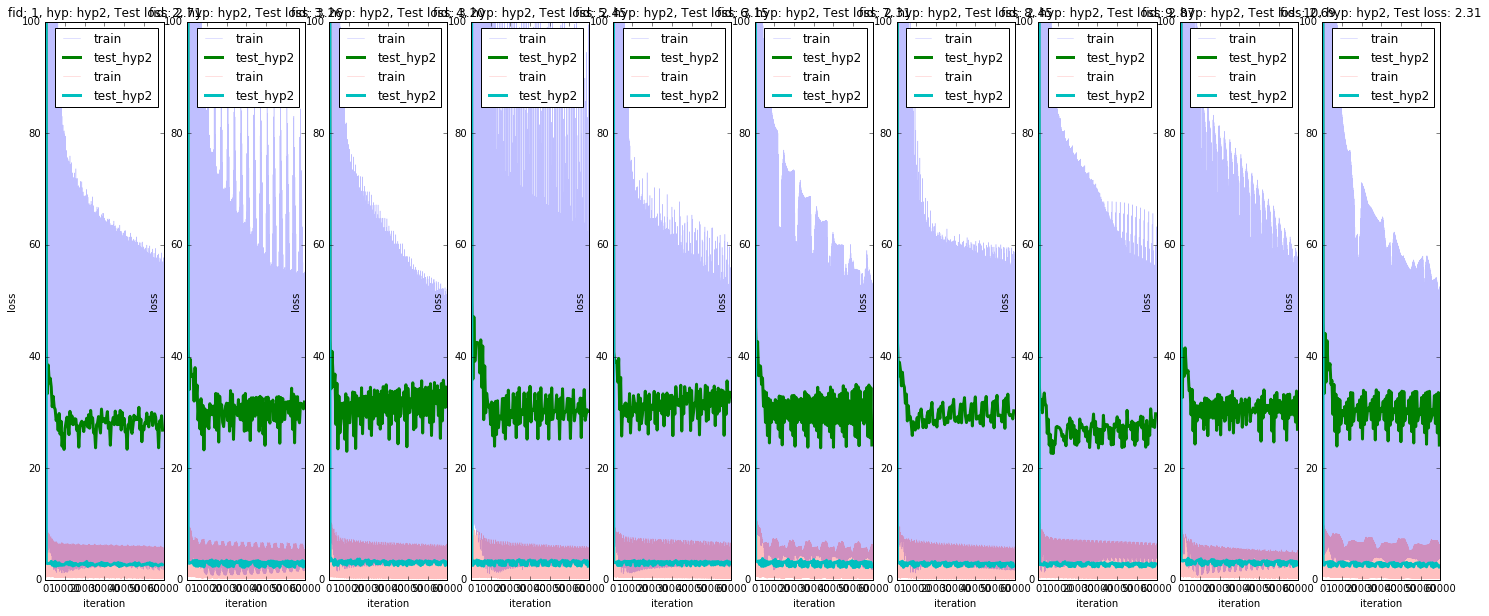

In [29]:
# plot train loss and acc
plt.rcParams['figure.figsize'] = (25, 10)
#niter = 30000
test_interval = 500
n_mc = len(CV_perf_MC.keys())

for m, mc in enumerate(CV_perf_MC.keys()): 
    CV_perf_hype = CV_perf_MC[mc]
    
    for hype in CV_perf_hype.keys(): 
        CV_perf = CV_perf_hype[hype]
        n_CV_configs = len(CV_perf)
        pid = m*n_CV_configs + 1
        
        for f, fid in enumerate(fid_list):  
            train_loss_list = CV_perf[fid]['train_loss']
            test_loss_list = CV_perf[fid]['test_loss']
            
            for train_loss, test_loss in zip(train_loss_list,test_loss_list):
                #plt.figure()
                ax1 = plt.subplot(n_mc,n_CV_configs,pid)            
                ax1.plot(arange(niter), train_loss, label='train',linewidth='.5',alpha=0.25)
                ax1.plot(test_interval * arange(len(test_loss)), test_loss, label='test_{}'.format(hype), linewidth='3')                            
                ax1.set_xlabel('iteration')
                ax1.set_ylabel('loss')
                ax1.set_title('fid: {}, hyp: {}, Test loss: {:.2f}'.format(fid, hype, test_loss[-1]))
                ax1.legend(loc=1)
                ax1.set_ylim(0,100)
            pid += 1

In [ ]:
exp_name = 'Exp11'
preproc = 'no_preproc'
modality = 'R_HC'
batch_size = 256
encoding_layer = 'code'
weight_layers = 'code'
multi_task = False

if modality in ['L_HC', 'R_HC']:
    snap_iter = 10000
    
    if modality == 'R_HC':
        output_node_size = 16471
    else: 
        output_node_size = 16086
        
    hype_configs = {
                   'hyp1':{'node_sizes':{'En1':10000,'En2':2000,'code':8000,'out':output_node_size},
                  'dr':{'HC':0,'CT':0,'COMB':0},'lr':{'HC':2,'CT':2},
                  'solver_conf':{'base_lr':1e-5, 'wt_decay':1e-3}}
    }

elif modality in ['CT']:  
    snap_iter = 100000
    
    hype_configs = {
                    'hyp1':{'node_sizes':{'code':600,'out':686},
                      'dr':{'HC':0,'CT':0,'HC_CT':0,'COMB':0},'lr':{'HC':2,'CT':2,'HC_CT':2},'tr':{'ADAS':1,'MMSE':2,'DX':1},
                      'solver_conf':{'base_lr':1e-4, 'wt_decay':1e-3}}
    }
    
elif modality in ['HC_CT']:  
    snap_iter = 20000
    hype_configs = {
                 'hyp1':{'node_sizes':{'En1':10000,'En2':2000,'code':500,'out_HC':16086,'out_CT':686},
                  'dr':{'HC':0,'CT':0,'COMB':0},'lr':{'HC':2,'CT':2},
                  'solver_conf':{'base_lr':1e-5, 'wt_decay':1e-3}}
    }
    
hype = 'hyp1'
pretrain_preproc = 'ae_preproc_sparse_HC_10k_CT_100k_{}'.format(hype)
fid = 1
node_sizes = hype_configs[hype]['node_sizes']
dr = hype_configs[hype]['dr']
lr = hype_configs[hype]['lr']

# Save either L or R HC encodings. Turn on CT + CS save only for one of these. 
# (Also decide if you want to copy CT raw scores or encodings)
save_encodings = True
save_scores = False
CT_encodings = True

for cohort in ['inner_train', 'inner_test','outer_test']:
    data_path = baseline_dir + 'API/data/fold{}/{}/{}_{}.h5'.format(fid,cohort,exp_name,preproc)
    test_filename_txt = baseline_dir + 'API/data/fold{}/test_C688.txt'.format(fid)
    test_net_path = baseline_dir + 'API/data/fold{}/ADNI_AE_test.prototxt'.format(fid)       
    input_nodes = ['X_{}'.format(modality)]
    #input_nodes = ['X_L_HC','X_CT']
    net_file = baseline_dir + 'API/data/fold{}/ADNI_AE_test.prototxt'.format(fid)
    with open(net_file, 'w') as f:
        f.write(str(adninet_ae(test_filename_txt, 256, node_sizes,modality)))

    test_filename_hdf = baseline_dir + 'API/data/fold{}/{}/{}_{}.h5'.format(fid,cohort,exp_name,preproc)
    test_filename_txt = baseline_dir + 'API/data/fold{}/{}_C688.txt'.format(fid,cohort)
    with open(test_filename_txt, 'w') as f:
        f.write(test_filename_hdf + '\n') 

    sub.call(["cp", baseline_dir + 'API/data/fold{}/{}_C688.txt'.format(fid,cohort), baseline_dir + 'API/data/fold{}/test_C688.txt'.format(fid)])

    if modality == 'CT':
        model_file = baseline_dir + 'API/data/fold{}/train_snaps/{}_{}_{}_iter_{}.caffemodel'.format(fid,exp_name,hype,modality,snap_iter)  
    else:
        model_file = baseline_dir + 'API/data/fold{}/train_snaps/{}_{}_{}_iter_{}.caffemodel'.format(fid,exp_name,hype,modality,snap_iter)  
        
    print 'Check Sparsity for model: {}'.format(model_file)
    
    results = extract_features(net_file, model_file, data_path, input_nodes, batch_size, encoding_layer, weight_layers,multi_task)
    encodings = np.squeeze(results['X_out'])      
    
    encodings_hdf_file = baseline_dir + 'API/data/fold{}/{}/{}_{}.h5'.format(fid,cohort,exp_name,pretrain_preproc)
    
    if save_encodings:    
        input_data = h5py.File(encodings_hdf_file, 'a')
        input_data.create_dataset(input_nodes[0],data=encodings)           
        input_data.close()
        
    if save_scores:
        input_data = h5py.File(encodings_hdf_file, 'a')
        if not CT_encodings: #copy raw scores for CT instead of encodings
            CT_data = load_data(data_path, 'X_CT','no_preproc')                    
            input_data.create_dataset('X_CT', data=CT_data)    
            
        adas_scores = load_data(data_path, 'y','no_preproc')
        mmse_scores = load_data(data_path, 'y3','no_preproc')
        dx_labels = load_data(data_path, 'dx_cat3','no_preproc')
        input_data.create_dataset('y', data=adas_scores)           
        input_data.create_dataset('y3', data=mmse_scores)    
        input_data.create_dataset('dx_cat3', data=dx_labels)
        input_data.close()
    

In [ ]:
# Plotting TSNE embeddings 
from sklearn.manifold import TSNE

exp_name = 'Exp11'
#preproc = 'no_preproc'
#preproc = 'ae_preproc_sparse_HC_10k_CT_100k_hyp1'
Clinical_Scale = 'ADAS13_DX' 
batch_size = 256
snap_interval = 2000
snap_start = 2000
encoding_layer = 'ff3'
weight_layers = 'ff3'
cohort = 'outer_test'
multi_task = False

modality = 'HC_CT'
snap_end = 21000


hype_configs = {
            'hyp1':{'node_sizes':{'HC_L_ff':25,'HC_R_ff':25,'CT_ff':25,'HC_CT_ff':25,'COMB_ff':25,'ADAS_ff':25,'MMSE_ff':25,'DX_ff':25,
                                       'En1':10000,'En2':2000,'code':600,'out':686},
                      'dr':{'HC':0,'CT':0,'HC_CT':0,'COMB':0},'lr':{'HC':2,'CT':2,'HC_CT':2},'tr':{'ADAS':1,'MMSE':2,'DX':1},
                      'solver_conf':{'base_lr':1e-6, 'wt_decay':1e-2}},
}

hype = 'hyp1'
fid = 1
node_sizes = hype_configs[hype]['node_sizes']
dr = hype_configs[hype]['dr']
lr = hype_configs[hype]['lr']
tr = hype_configs[hype]['tr']

data_path = baseline_dir + 'API/data/fold{}/{}/{}_{}.h5'.format(fid,cohort,exp_name,preproc)
test_filename_txt = baseline_dir + 'API/data/fold{}/test_C688.txt'.format(fid)
test_net_path = baseline_dir + 'API/data/fold{}/ADNI_ff_test.prototxt'.format(fid)       
#input_node = 'X_{}'.format(modality)

net_file = baseline_dir + 'API/data/fold{}/ADNI_ff_test.prototxt'.format(fid)
with open(net_file, 'w') as f:
    #f.write(str(adninet_ae(test_filename_txt, 256, node_sizes,modality)))
    f.write(str(adninet_ff_HC_CT(test_filename_txt, 256, node_sizes,dr,lr,tr,Clinical_Scale)))
    input_nodes = ['X_L_HC','X_R_HC','X_CT']

test_filename_hdf = baseline_dir + 'API/data/fold{}/{}/{}_{}.h5'.format(fid,cohort,exp_name,preproc)
test_filename_txt = baseline_dir + 'API/data/fold{}/{}_C688.txt'.format(fid,cohort)
with open(test_filename_txt, 'w') as f:
    f.write(test_filename_hdf + '\n') 

sub.call(["cp", baseline_dir + 'API/data/fold{}/{}_C688.txt'.format(fid,cohort), baseline_dir + 'API/data/fold{}/test_C688.txt'.format(fid)])

n_snaps = len(np.arange(snap_start,snap_end,snap_interval))
tsne_encodings = {}
net_weights = {}
for sn, snap_iter in enumerate(np.arange(snap_start,snap_end,snap_interval)):
    print sn, snap_iter
    model_file = baseline_dir + 'API/data/fold{}/train_snaps/{}_{}_{}_iter_{}.caffemodel'.format(fid,exp_name,hype,modality,snap_iter)        
    results = extract_features(net_file, model_file, data_path, input_nodes, batch_size, encoding_layer, weight_layers,multi_task)
    encodings = np.squeeze(results['X_out'])      
    net_weights[snap_iter] = results['wt_dict']
    print encodings.shape

    adas_scores = load_data(data_path, 'y','no_preproc')
    mmse_scores = load_data(data_path, 'y3','no_preproc')
    dx_labels = load_data(data_path, 'dx_cat3','no_preproc')
    tsne_model = TSNE(n_components=2, random_state=0, init='pca')
    tsne_encodings[snap_iter] = tsne_model.fit_transform(encodings) 
    

In [ ]:
plt.rcParams['figure.figsize'] = (20, 20)
plot_encodings = True
plot_wts = False

color_scores = dx_labels
cm = plt.get_cmap('RdYlBu') 
marker_size = 100
marker_size = (np.mod(color_scores+1,2)+1)*50

for sn, snap_iter in enumerate(np.arange(snap_start,snap_end,snap_interval)):
    plt.subplot(np.ceil(n_snaps/2.0),2,sn+1)
    if plot_encodings:
        plt.scatter(tsne_encodings[snap_iter][:,0],tsne_encodings[snap_iter][:,1],c=color_scores,s=marker_size,cmap=cm)
    if plot_wts:
        plt.imshow(net_weights[snap_iter][weight_layers])
        
    plt.title(snap_iter)
    plt.colorbar()


In [10]:
#Get encodings after training
#train_filename_hdf = baseline_dir + 'data/train_CT_C688_normed.h5'
#test_filename_hdf = baseline_dir + 'data/test_CT_C688_normed.h5'
#fid=2
#exp_name = 'Exp11'
#niter = 40000
# modality = 'HC_CT'
start_fold = 1
n_folds = 10
fid_list = np.arange(start_fold,n_folds+1,1)
#preproc = 'no_preproc'
#batch_size = 256
snap_interval = 4000
snap_start = 4000
encoding_layer = 'output'
weight_layers = 'output'
cohort = 'outer_test'
#Clinical_Scale = 'ADAS13'

MC_list = np.arange(1,11,1)

if Clinical_Scale in ['ADAS13', 'MMSE']:
    fold_euLoss = {}
    fold_r = {}
    fold_act_scores = {}
    fold_pred_scores = {}
elif Clinical_Scale == 'BOTH':
    fold_euLoss_adas13 = {}
    fold_r_adas13 = {}
    fold_act_scores_adas13 = {}
    fold_pred_scores_adas13 = {}
    fold_euLoss_mmse = {}
    fold_r_mmse = {}
    fold_act_scores_mmse = {}
    fold_pred_scores_mmse = {}
    
idx = 0  
df_perf_dict_adas = {}
df_perf_dict_mmse = {}
df_perf_dict_adas_tuned = {}
df_perf_dict_mmse_tuned = {}
df_perf_dict_opt = {}

for mc in MC_list:
    print exp_name, mc, modality

    for hype in hype_configs.keys():      
        node_sizes = hype_configs[hype]['node_sizes']
        dr = hype_configs[hype]['dr']
        lr = hype_configs[hype]['lr']

        for fid in fid_list:
            test_filename_txt = baseline_dir + 'API/data/MC_{}/fold{}/test_C688.txt'.format(mc,fid)
            #test_filename_hdf = baseline_dir + 'API/data/fold{}/outer_test/{}_{}.h5'.format(fid,exp_name,preproc)
            #with open(test_filename_txt, 'w') as f:
            #        f.write(test_filename_hdf + '\n')  

            test_net_path = baseline_dir + 'API/data/MC_{}/fold{}/ADNI_FF_test.prototxt'.format(mc,fid)
            with open(test_net_path, 'w') as f:
                if modality == 'HC':
                    f.write(str(adninet_ff_HC(test_filename_txt, batch_size, node_sizes,dr,lr,tr,Clinical_Scale)))
                    input_nodes = ['X_L_HC','X_R_HC']
                elif modality == 'CT':
                    f.write(str(adninet_ff_CT(test_filename_txt, batch_size, node_sizes,dr,lr,tr,Clinical_Scale)))
                    input_nodes = ['X_CT_SpecCluster_dyn']
                elif modality == 'HC_CT':
                    f.write(str(adninet_ff_HC_CT(test_filename_txt, batch_size, node_sizes,dr,lr,tr,Clinical_Scale)))
                    input_nodes = ['X_L_HC','X_R_HC','X_CT_SpecCluster_dyn']
                elif modality == 'HC_CT_unified_hyp1':
                    f.write(str(adninet_ff_HC_CT_unified(test_filename_txt, batch_size, node_sizes,dr,lr,tr,Clinical_Scale)))
                    input_nodes = ['X_HC_CT']
                else:
                    print 'Wrong modality'

            #print 'Hype # {}, MC # {}, Fold # {}, Clinical_Scale {}'.format(hype, mc, fid, Clinical_Scale)
            data_path = baseline_dir + 'API/data/MC_{}/fold{}/{}/{}.h5'.format(mc,fid,cohort,exp_name)
            if Clinical_Scale == 'ADAS13':
                act_scores = load_data(data_path, 'adas','no_preproc')
            elif Clinical_Scale == 'MMSE': 
                act_scores = load_data(data_path, 'mmse','no_preproc')
            elif Clinical_Scale == 'BOTH':
                act_scores_adas13 = load_data(data_path, 'adas','no_preproc')
                act_scores_mmse = load_data(data_path, 'mmse','no_preproc')
            else:
                print 'unknown clinical scale'

            net_file = baseline_dir + 'API/data/MC_{}/fold{}/ADNI_FF_test.prototxt'.format(mc,fid)
            test_filename_hdf = baseline_dir + 'API/data/MC_{}/fold{}/{}/{}.h5'.format(mc,fid,cohort,exp_name)
            test_filename_txt = baseline_dir + 'API/data/MC_{}/fold{}/{}_C688.txt'.format(mc,fid,cohort)
            with open(test_filename_txt, 'w') as f:
                    f.write(test_filename_hdf + '\n')  

            sub.call(["cp", baseline_dir + 'API/data/MC_{}/fold{}/{}_C688.txt'.format(mc,fid,cohort), baseline_dir + 
                      'API/data/MC_{}/fold{}/test_C688.txt'.format(mc,fid)])
            #data_path = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/CV_Exp4_ADNI1_ADAS13_NN_valid.h5'
            #adas_scores = load_data(data_path, 'Fold_{}_y'.format(fid),'no_preproc')

            if Clinical_Scale in ['ADAS13', 'MMSE']:                
                multi_task = False
                cs_list = ['opt']
                iter_euLoss = []
                iter_r = []        
                iter_pred_scores = []
                for snap_iter in np.arange(snap_start,niter+1,snap_interval):
                    model_file = baseline_dir + 'API/data/MC_{}/fold{}/train_snaps/{}_{}_{}_iter_{}.caffemodel'.format(mc,fid,exp_name,hype,modality,snap_iter)        
                    results = extract_features(net_file, model_file, data_path, input_nodes, batch_size, encoding_layer, weight_layers,multi_task)
                    encodings = np.squeeze(results['X_out'])            
                    iter_pred_scores.append(np.squeeze(results['X_out']))            
                    iter_euLoss.append(0.5*mse(encodings,act_scores))  #This is to be consistent with the caffe loss funtion
                    iter_r.append(stats.pearsonr(encodings,act_scores)[0])

                config_idx = '{}_{}'.format(hype,fid)
                fold_euLoss[config_idx] = np.array(iter_euLoss)
                fold_r[config_idx] = np.array(iter_r)
                fold_act_scores[fid] = act_scores
                fold_pred_scores[config_idx] = np.array(iter_pred_scores)        

            elif Clinical_Scale == 'BOTH':
                multi_task = True
                cs_list = ['adas','mmse']
                iter_euLoss_adas13 = []
                iter_r_adas13 = []        
                iter_pred_scores_adas13 = []
                iter_euLoss_mmse = []
                iter_r_mmse = []        
                iter_pred_scores_mmse = []

                for snap_iter in np.arange(snap_start,niter+1,snap_interval):
                    model_file = baseline_dir + 'API/data/MC_{}/fold{}/train_snaps/{}_{}_{}_iter_{}.caffemodel'.format(mc,fid,exp_name,hype,modality,snap_iter)        
                    results = extract_features(net_file, model_file, data_path, input_nodes, batch_size, encoding_layer, weight_layers,multi_task)
                    encodings = results['X_out']   
                    encodings_adas13 = np.squeeze(encodings['adas13'])
                    encodings_mmse = np.squeeze(encodings['mmse'])
                    iter_pred_scores_adas13.append(encodings_adas13)            
                    iter_pred_scores_mmse.append(encodings_mmse)                 
                    iter_euLoss_adas13.append(0.5*mse(encodings_adas13,act_scores_adas13))  #This is to be consistent with the caffe loss funtion
                    iter_euLoss_mmse.append(0.5*mse(encodings_mmse,act_scores_mmse))  #This is to be consistent with the caffe loss funtion
                    iter_r_adas13.append(stats.pearsonr(encodings_adas13,act_scores_adas13)[0])                                
                    iter_r_mmse.append(stats.pearsonr(encodings_mmse,act_scores_mmse)[0])

                config_idx = '{}_{}'.format(hype,fid)
                fold_euLoss_adas13[config_idx] = np.array(iter_euLoss_adas13)
                fold_r_adas13[config_idx] = np.array(iter_r_adas13)
                fold_act_scores_adas13[fid] = act_scores_adas13
                fold_pred_scores_adas13[config_idx] = np.array(iter_pred_scores_adas13)        
                fold_euLoss_mmse[config_idx] = np.array(iter_euLoss_mmse)
                fold_r_mmse[config_idx] = np.array(iter_r_mmse)
                fold_act_scores_mmse[fid] = act_scores_mmse
                fold_pred_scores_mmse[config_idx] = np.array(iter_pred_scores_mmse)        

    
    if Clinical_Scale in ['ADAS13', 'MMSE']:
        fold_perf_dict = {'fold_r':fold_r,'fold_euLoss':fold_euLoss,'fold_act_scores':fold_act_scores,'fold_pred_scores':fold_pred_scores}
    else: 
        fold_perf_dict = {'fold_r_adas13':fold_r_adas13,'fold_r_mmse':fold_r_mmse,'fold_euLoss_adas13':fold_euLoss_adas13,'fold_euLoss_mmse':fold_euLoss_mmse,
                         'fold_act_scores_adas13':fold_act_scores_adas13,'fold_act_scores_mmse':fold_act_scores_mmse,
                          'fold_pred_scores_adas13':fold_pred_scores_adas13,'fold_pred_scores_mmse':fold_pred_scores_mmse}
        
    opt_metric = 'euLoss' #euLoss or corr or both
    #task_weights = {'ADAS':1,'MMSE':0} 
    save_multitask_results = False
    CV_model_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/NN_MC/output/'  
    save_path = '{}{}_{}_NN_{}'.format(CV_model_dir,exp_name,mc,modality)
    
    # Create dictionaries of perfromance based on differnt task weights 
    for key, task_weights in {'adas':{'ADAS':1,'MMSE':0},'mmse':{'ADAS':0,'MMSE':1},'both':{'ADAS':1,'MMSE':1}}.items():
        print 'Weights Tuned for: {}'.format(key)                              
        results = compute_MC_results(fold_perf_dict, multi_task, opt_metric, task_weights, save_multitask_results, save_path)  

        # populate the perf dictionary for 10 MC x 10 folds
        model_choice = 'APANN'    
        for f, fid in enumerate(fid_list): 
            if key in ['adas','mmse']:
                r_valid = results['{}_r'.format(key)][f]
                MSE_valid = results['{}_mse'.format(key)][f]
                RMSE_valid = results['{}_rmse'.format(key)][f]

                if key == 'adas':
                    df_perf_dict_adas_tuned[idx] = {'MC':mc,'modality':modality,'model_choice':model_choice,'KF':fid,
                                         'CV_MSE':MSE_valid,'CV_RMSE':RMSE_valid,'CV_r':r_valid,'CV_R2':0}
                elif key == 'mmse':
                    df_perf_dict_mmse_tuned[idx] = {'MC':mc,'modality':modality,'model_choice':model_choice,'KF':fid,
                                         'CV_MSE':MSE_valid,'CV_RMSE':RMSE_valid,'CV_r':r_valid,'CV_R2':0}
                else: 
                    print 'unknown key'

            elif key == 'both':                    
                for cs in cs_list:            
                    r_valid = results['{}_r'.format(cs)][f]
                    MSE_valid = results['{}_mse'.format(cs)][f]
                    RMSE_valid = results['{}_rmse'.format(cs)][f]

                    if cs == 'adas':
                        df_perf_dict_adas[idx] = {'MC':mc,'modality':modality,'model_choice':model_choice,'KF':fid,
                                         'CV_MSE':MSE_valid,'CV_RMSE':RMSE_valid,'CV_r':r_valid,'CV_R2':0}
                    elif cs == 'mmse':
                        df_perf_dict_mmse[idx] = {'MC':mc,'modality':modality,'model_choice':model_choice,'KF':fid,
                                         'CV_MSE':MSE_valid,'CV_RMSE':RMSE_valid,'CV_r':r_valid,'CV_R2':0}                    
                    else: 
                        print 'unknown key'


            else: #single task dictionary
                df_perf_dict_opt[idx] = {'MC':mc,'modality':modality,'model_choice':model_choice,'KF':fid,
                                         'CV_MSE':MSE_valid,'CV_RMSE':RMSE_valid,'CV_r':r_valid,'CV_R2':0}

            idx+=1

Exp13_MC 1 HC
Weights Tuned for: both
Clinical_Scale: BOTH
ADAS corr: [0.54406000313806924, 0.54560523578529063, 0.4372843423311214, 0.61992111073867262, 0.58947870471460995, 0.66553232831036147, 0.36680928902938753, 0.48864912744345623, 0.55187475560361055, 0.51589872395238223]
ADAS mse: [63.966946844388168, 62.487979233456969, 72.295800099522609, 60.896080650849136, 51.503799996591546, 43.895859429719906, 95.830896247947933, 67.974543525135303, 53.779403711744926, 72.342211502552516]
ADAS means: 0.532511362105, 64.4973521242

MMSE corr: [0.48085545186748596, 0.46072877924673727, 0.4576762726218831, 0.45657565887311136, 0.45516869779664976, 0.44546524724649522, 0.26952780500860996, 0.42059680391658666, 0.47235630106116577, 0.37215395416036906]
MMSE mse: [5.6812780784361516, 5.5268505273065589, 5.3315840348314998, 6.2717487010627107, 5.8659336014421486, 5.8587104805557617, 7.9611724175712011, 5.5613612708417728, 5.0962414624342012, 6.5483450078306911]
MMSE means: 0.42911049718, 5.97032

RuntimeError: Could not open file /projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/NN_MC/API/data/MC_10/fold6/train_snaps/Exp13_MC_hyp1_HC_iter_4000.caffemodel

In [11]:
#Save df style dictionaly for seaborn plots
cohort = 'ADNI1and2'
df_perf_dict_path = CV_model_dir + 'df_perf_dict_{}_{}_{}_ADAS13.pkl'.format(exp_name, cohort,modality)                
pickleIt(df_perf_dict_adas,df_perf_dict_path)
df_perf_dict_path = CV_model_dir + 'df_perf_dict_{}_{}_{}_MMSE.pkl'.format(exp_name, cohort,modality)  
pickleIt(df_perf_dict_mmse,df_perf_dict_path)

df_perf_dict_path = CV_model_dir + 'df_perf_dict_{}_{}_{}_ADAS13_tuned.pkl'.format(exp_name,cohort,modality)                
pickleIt(df_perf_dict_adas_tuned,df_perf_dict_path)
df_perf_dict_path = CV_model_dir + 'df_perf_dict_{}_{}_{}_MMSE_tuned.pkl'.format(exp_name, cohort,modality)  
pickleIt(df_perf_dict_mmse_tuned,df_perf_dict_path)


print 'saving results at: {}'.format(CV_model_dir)

saving results at: /projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/NN_MC/output/


In [ ]:
plt.rcParams['figure.figsize'] = (20, 25)
n_rows = n_folds
n_cols = 2
pid = 1
plot_perf = False

if multi_task:
    euLosses = [fold_euLoss_adas13,fold_euLoss_mmse]
    corrs = [fold_r_adas13,fold_r_mmse]
else:
    euLosses = [fold_euLoss]
    corrs = [fold_r]
    
for fold_euLoss, fold_r in zip(euLosses, corrs):
    for hype_fid in fold_euLoss.keys():
        hype = int(hype_fid.split('_')[0][3])
        fid = int(hype_fid.split('_')[1])    
        
        if plot_perf:
            plt.figure(fid)
            plt.subplot(n_rows,n_cols,1)
            plt.plot(np.arange(snap_start,niter+1,snap_interval),fold_euLoss[hype_fid],label=hype_fid)
            plt.title('Euclidean loss , fid: {}'.format(fid))
            plt.legend()
            plt.subplot(n_rows,n_cols,2)
            plt.plot(np.arange(snap_start,niter+1,snap_interval),fold_r[hype_fid],label=hype_fid)
            plt.title('correlation, fid: {}'.format(fid))
            plt.legend(loc=2)

print preproc

In [8]:
def compute_MC_results(fold_perf_dict, multi_task, opt_metric, task_weights, save_multitask_results, save_path):
    fold_r_dict = {}
    fold_euLoss_dict = {}
    fold_act_scores_dict = {}
    fold_pred_scores_dict = {}

    if multi_task:
        fold_r_dict['ADAS'] = fold_perf_dict['fold_r_adas13']
        fold_r_dict['MMSE'] = fold_perf_dict['fold_r_mmse']
        fold_euLoss_dict['ADAS'] = fold_perf_dict['fold_euLoss_adas13']
        fold_euLoss_dict['MMSE'] = fold_perf_dict['fold_euLoss_mmse']
        fold_act_scores_dict['ADAS'] = fold_perf_dict['fold_act_scores_adas13']
        fold_act_scores_dict['MMSE'] = fold_perf_dict['fold_act_scores_mmse']
        fold_pred_scores_dict['ADAS'] = fold_perf_dict['fold_pred_scores_adas13']
        fold_pred_scores_dict['MMSE'] = fold_perf_dict['fold_pred_scores_mmse']
        
        NN_results = computePerfMetrics(fold_r_dict, fold_euLoss_dict, fold_act_scores_dict, fold_pred_scores_dict, opt_metric, hype_configs, 
                                        Clinical_Scale,task_weights)
        adas_r = NN_results['opt_ADAS']['CV_r'].values()
        mmse_r = NN_results['opt_MMSE']['CV_r'].values()
        adas_mse = NN_results['opt_ADAS']['CV_MSE'].values()
        mmse_mse = NN_results['opt_MMSE']['CV_MSE'].values()
        adas_rmse = NN_results['opt_ADAS']['CV_RMSE'].values()
        mmse_rmse = NN_results['opt_MMSE']['CV_RMSE'].values()
        opt_hyp = NN_results['opt_hype']
        opt_snap = NN_results['opt_snap']
        predicted_CV_scores = NN_results['opt_ADAS']['predicted_CV_scores']
        actual_CV_scores = NN_results['opt_ADAS']['actual_CV_scores']
        
        print 'ADAS corr: {}'.format(adas_r)
        print 'ADAS mse: {}'.format(adas_mse)
        print 'ADAS means: {}, {}'.format(np.mean(adas_r),np.mean(adas_mse))
        print ''
        print 'MMSE corr: {}'.format(mmse_r)
        print 'MMSE mse: {}'.format(mmse_mse)
        print 'MMSE means: {}, {}'.format(np.mean(mmse_r),np.mean(mmse_mse))
        print ''
        print 'opt_hyp: {}'.format(opt_hyp)
        print ''
        print 'opt_snap: {}'.format(opt_snap)
        
        return {'adas_r':adas_r, 'adas_mse':adas_mse, 'adas_rmse':adas_rmse, 'mmse_r':mmse_r, 'mmse_mse':mmse_mse, 'mmse_rmse':mmse_rmse,
               'predicted_CV_scores':predicted_CV_scores,'actual_CV_scores':actual_CV_scores}

    else:    
        
        NN_results = computeSingleTaskPerfMetrics(fold_perf_dict, opt_metric, hype_configs)
        opt_r = NN_results['opt_r'].values()        
        opt_mse = NN_results['opt_mse'].values()        
        opt_rmse = NN_results['opt_rmse'].values()        
        opt_hyp = NN_results['opt_hype']
        opt_snap = NN_results['opt_snap']
        predicted_CV_scores = NN_results['predicted_CV_scores']
        actual_CV_scores = NN_results['actual_CV_scores']
        print 'opt corr: {}'.format(opt_r)
        print 'opt mse: {}'.format(opt_mse)
        print 'means: {}, {}'.format(np.mean(opt_r),np.mean(opt_mse))
        print ''
        print 'opt_snap: {}'.format(opt_snap)
        print ''
    
        return {'opt_r':opt_r, 'opt_mse':opt_mse, 'opt_rmse':opt_rmse,'predicted_CV_scores':predicted_CV_scores,'actual_CV_scores':actual_CV_scores}
    


    if save_multitask_results:
        ts = time.time()
        st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d-%H-%M-%S')        
        save_path = save_path + '_' + st + '.pkl' 
        print 'saving results at: {}'.format(save_path)
        output = open(save_path, 'wb')
        pickle.dump(NN_results, output)
        output.close()

    

In [10]:
a = np.squeeze(results['predicted_CV_scores'][7])
b = np.squeeze(results['actual_CV_scores'][7])

print a , b                               
print stats.pearsonr(a,b)

KeyError: 'predicted_CV_scores'

In [9]:
# Compute ptimal hyp_config for each fold(based on inner_test)
# if multi_task is set then compute hyp_config based on ADAS+MMSE perf (mse, r values)
# if multi_task is set then ADAS and MMSE act_scores and pred_scores are wrapped in dictionaries 
# task_weights: dict of weights for each task --> only used in Clinical_Scale = BOTH
# opt_metric = mse or corr
def computePerfMetrics(fold_r, fold_euLoss, fold_act_scores, fold_pred_scores, opt_metric, hype_configs, Clinical_Scale,task_weights):
    # First generate lists per fold with all hyp results
    fid_hype_map = defaultdict(list)
    fid_euLoss_perf= defaultdict(list)
    fid_r_perf= defaultdict(list)
    
     # find optimal hyp_snp combination for each fold based on corr and euLoss
    opt_hype = {}
    opt_snap = {}

    opt_r_adas = {}
    opt_mse_adas = {}
    opt_rmse_adas = {}
    actual_scores_adas = defaultdict(list)
    opt_pred_scores_adas = defaultdict(list)

    opt_r_mmse = {}
    opt_mse_mmse = {}
    opt_rmse_mmse = {}
    actual_scores_mmse = defaultdict(list)
    opt_pred_scores_mmse = defaultdict(list)

    print 'Clinical_Scale: {}'.format(Clinical_Scale)
    if not Clinical_Scale == 'BOTH':  #Does not produce all the metrics yet..
        print 'This function does not work for single clinical scale models. Use the code from the next cell'
    
    else:
        fold_r_ADAS = fold_r['ADAS']
        fold_r_MMSE = fold_r['MMSE']
        fold_euLoss_ADAS = fold_euLoss['ADAS']
        fold_euLoss_MMSE = fold_euLoss['MMSE']
        fid_r_perf_ADAS = defaultdict(list)
        fid_r_perf_MMSE = defaultdict(list)
        fid_euLoss_perf_ADAS = defaultdict(list)
        fid_euLoss_perf_MMSE = defaultdict(list)
        for hype_fid in fold_euLoss_ADAS.keys():
            hype = int(hype_fid.split('_')[0][3])
            fid = int(hype_fid.split('_')[1]) 
            
            fid_r_perf_ADAS[fid].append(fold_r_ADAS[hype_fid])
            fid_r_perf_MMSE[fid].append(fold_r_MMSE[hype_fid])
            fid_euLoss_perf_ADAS[fid].append(fold_euLoss_ADAS[hype_fid])
            fid_euLoss_perf_MMSE[fid].append(fold_euLoss_MMSE[hype_fid])
            fid_hype_map[fid].append(hype)
            
            #Joint scores (weighted addition)
            fid_r_perf[fid].append(task_weights['ADAS']*fold_r_ADAS[hype_fid] + task_weights['MMSE']*fold_r_MMSE[hype_fid])
            fid_euLoss_perf[fid].append(task_weights['ADAS']*fold_euLoss_ADAS[hype_fid] + task_weights['MMSE']*fold_euLoss_MMSE[hype_fid])

        fold_act_scores_adas = fold_act_scores['ADAS']
        fold_act_scores_mmse = fold_act_scores['MMSE']
        fold_pred_scores_adas = fold_pred_scores['ADAS']
        fold_pred_scores_mmse = fold_pred_scores['MMSE']

        for fid in fid_hype_map.keys():
            r_perf_array_adas = np.array(fid_r_perf_ADAS[fid])
            r_perf_array_mmse = np.array(fid_r_perf_MMSE[fid])
            r_perf_array = np.array(fid_r_perf[fid])
            euLoss_perf_array_adas = np.array(fid_euLoss_perf_ADAS[fid])
            euLoss_perf_array_mmse = np.array(fid_euLoss_perf_MMSE[fid])
            euLoss_perf_array = np.array(fid_euLoss_perf[fid])

            if opt_metric == 'euLoss':
                h,snp = np.unravel_index(euLoss_perf_array.argmin(), euLoss_perf_array.shape)
            else:
                h,snp = np.unravel_index(r_perf_array.argmax(), r_perf_array.shape)

            opt_hype[fid] = hype_configs['hyp{}'.format(fid_hype_map[fid][h])]
            opt_snap[fid] = snp

            opt_r_adas[fid] = r_perf_array_adas[h,snp]
            opt_mse_adas[fid] = 2*euLoss_perf_array_adas[h,snp] #Convert back to MSE
            opt_rmse_adas[fid] = np.sqrt(2*euLoss_perf_array_adas[h,snp]) #RMSE
            opt_r_mmse[fid] = r_perf_array_mmse[h,snp] 
            opt_mse_mmse[fid] = 2*euLoss_perf_array_mmse[h,snp] #Convert back to MSE
            opt_rmse_mmse[fid] = np.sqrt(2*euLoss_perf_array_mmse[h,snp]) #RMSE

            actual_scores_adas[fid].append(fold_act_scores_adas[fid])
            opt_pred_scores_adas[fid].append(fold_pred_scores_adas['hyp{}_{}'.format(fid_hype_map[fid][h],fid)][snp])
            actual_scores_mmse[fid].append(fold_act_scores_mmse[fid])
            opt_pred_scores_mmse[fid].append(fold_pred_scores_mmse['hyp{}_{}'.format(fid_hype_map[fid][h],fid)][snp])

        opt_ADAS = {'CV_r':opt_r_adas,'CV_MSE':opt_mse_adas,'CV_RMSE':opt_rmse_adas,'actual_CV_scores':actual_scores_adas,'predicted_CV_scores':opt_pred_scores_adas}
        opt_MMSE = {'CV_r':opt_r_mmse,'CV_MSE':opt_mse_mmse,'CV_RMSE':opt_rmse_mmse,'actual_CV_scores':actual_scores_mmse,'predicted_CV_scores':opt_pred_scores_mmse}
    
    return {'opt_hype':opt_hype, 'opt_snap':opt_snap, 'opt_ADAS':opt_ADAS, 'opt_MMSE':opt_MMSE}


In [ ]:
# Find optimal config based on inner_test
def computeSingleTaskPerfMetrics(fold_perf_dict,opt_metric,hype_configs):
    corrs = fold_perf_dict['fold_r']
    euLosses = fold_perf_dict['fold_euLoss']
    act_scores = fold_perf_dict['fold_act_scores']
    pred_scores = fold_perf_dict['fold_pred_scores']

    
    NN_multitask_results = {}
   
    snap_array = np.arange(snap_start,niter+1,snap_start)

    fid_hype_map = defaultdict(list)
    fid_euLoss_perf= defaultdict(list)
    fid_r_perf= defaultdict(list)
    for hype_fid in fold_euLoss.keys():
        hype = int(hype_fid.split('_')[0][3])
        fid = int(hype_fid.split('_')[1])
        fid_euLoss_perf[fid].append(fold_euLoss[hype_fid])
        fid_r_perf[fid].append(fold_r[hype_fid])
        fid_hype_map[fid].append(hype)

    opt_r = {}
    opt_mse = {}
    opt_rmse = {}
    opt_hype = {}
    opt_snap = {}
    actual_scores = {}
    opt_pred_scores = {}

    for fid in fid_hype_map.keys():
        r_perf_array = np.array(fid_r_perf[fid])
        euLoss_perf_array = np.array(fid_euLoss_perf[fid])

        # if want to find best hyp from mse values
        if opt_metric == 'euLoss':
            h,snp = np.unravel_index(euLoss_perf_array.argmin(), euLoss_perf_array.shape)
        else:
            h,snp = np.unravel_index(r_perf_array.argmax(), r_perf_array.shape)
            
        eu_loss = euLoss_perf_array[h,snp]
        r = r_perf_array[h,snp]        
        opt_r[fid] = r
        opt_mse[fid] = 2*eu_loss
        opt_rmse[fid] = np.sqrt(2*eu_loss)
        #print 'fid:{}, best hype:{}, snap: {}, euLoss:{}'.format(fid, fid_hype_map[fid][h],snap_array[snp],eu_loss)        
        opt_snap[fid] = snp
        opt_hype[fid] = hype_configs['hyp{}'.format(fid_hype_map[fid][h])]
        actual_scores[fid] = fold_act_scores[fid]
        opt_pred_scores[fid] = fold_pred_scores['hyp{}_{}'.format(fid_hype_map[fid][h],fid)][snp]

    #print 'CV Perf: r:{}, mse:{}'.format(np.mean(opt_r.values()), np.mean(opt_mse.values()))
    #print opt_r
    #print opt_mse
    return {'opt_r':opt_r,'opt_mse':opt_mse,'opt_rmse':opt_rmse,'opt_hype':opt_hype,'opt_snap':opt_snap, 'actual_scores':actual_scores,'opt_pred_scores':opt_pred_scores}


In [ ]:
boxplots_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/montage_data/'

model_file = 'Exp6_ADNI1_ADAS13_NN_HC_CT_2016-05-06-17-14-49.pkl'
print model_file
CV_data = pickle.load(open(boxplots_dir + model_file,'rb'))

print 'old CV_r: {}'.format(CV_data['CV_r'])
print ''
print 'old mean(CV_r): {}, mean(MSE): {}'.format(np.mean(CV_data['CV_r']),np.mean(CV_data['CV_MSE']))
print ''
print 'old CV_mse: {}'.format(CV_data['CV_MSE'])
#print CV_data['tid_snap_config_dict']

NN_results = {}
NN_results['CV_MSE'] = opt_mse
NN_results['CV_r'] = opt_r
NN_results['predicted_CV_scores'] = opt_pred_scores
NN_results['actual_CV_scores'] = actual_scores
NN_results['tid_snap_config_dict'] = opt_hype

# #Combine second saved perf file with the previous one
# model_file_2 = 'Exp11_ADNI2_ADAS13_NN_HC_CT_2016-05-06-00-03-01.pkl'
# print model_file
# NN_results = pickle.load(open(boxplots_dir + model_file_2,'rb'))

idx_pairs = {4:0,5:1}
updated_CV_data = update_fold_perf(boxplots_dir + model_file, NN_results, idx_pairs)
print ''
print 'new CV_r: {}'.format(updated_CV_data['CV_r'])
print ''
print 'new mean(CV_r): {}, mean(MSE): {}'.format(np.mean(updated_CV_data['CV_r']),np.mean(updated_CV_data['CV_MSE']))
print ''
print 'new CV_mse: {}'.format(updated_CV_data['CV_MSE'])

save_updated_perf = False
if save_updated_perf:
    ts = time.time()
    st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d-%H-%M-%S')
    montage_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/montage_data/'  
    save_name = '{}Exp6_ADNI1_ADAS13_NN_{}_{}.pkl'.format(montage_dir,modality,st)
    print 'saving results at: {}'.format(save_name)
    output = open(save_name, 'wb')
    pickle.dump(updated_CV_data, output)
    output.close()
    

In [ ]:
np.sqrt(5.64658243068)

In [ ]:
#Update fold performance for multitask
print NN_results['opt_ADAS'].keys()

boxplots_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/montage_data/'
#model_file = 'Exp11_ADNI2_ADAS13_MMSE_NN_HC_CT_2016-06-04-13-15-43.pkl'
model_file_soa = 'Exp11_ADNI2_ADAS13_MMSE_NN_HC_CT_2016-08-24-14-23-52.pkl'
print 'current state of art: ' + model_file_soa
CV_data = pickle.load(open(boxplots_dir + model_file_soa,'rb'))

print 'ADAS'
print CV_data['opt_ADAS']['CV_r']
print CV_data['opt_ADAS']['CV_MSE']
print np.mean(CV_data['opt_ADAS']['CV_r'].values())
print np.mean(CV_data['opt_ADAS']['CV_MSE'].values())
print 'MMSE'
print CV_data['opt_MMSE']['CV_r']
print CV_data['opt_MMSE']['CV_MSE']
print np.mean(CV_data['opt_MMSE']['CV_r'].values())
print np.mean(CV_data['opt_MMSE']['CV_MSE'].values())

#load old file
# model_file = 'Exp11_ADNI2_ADAS13_MMSE_NN_HC_CT_2016-08-24-14-02-48.pkl'
# print 'updated fold result file: ' + model_file
# NN_results = pickle.load(open(boxplots_dir + model_file,'rb'))

idx_pairs = {1:1,3:3}
CV_data = update_multifold_perf(boxplots_dir + model_file_soa, NN_results, idx_pairs)

print ""
print 'updated CV_data'
print 'ADAS'
print CV_data['opt_ADAS']['CV_r']
print CV_data['opt_ADAS']['CV_MSE']
print np.mean(CV_data['opt_ADAS']['CV_r'].values())
print np.mean(CV_data['opt_ADAS']['CV_MSE'].values())
print 'MMSE'
print CV_data['opt_MMSE']['CV_r']
print CV_data['opt_MMSE']['CV_MSE']
print np.mean(CV_data['opt_MMSE']['CV_r'].values())
print np.mean(CV_data['opt_MMSE']['CV_MSE'].values())

save_name = '{}Exp11_ADNI2_ADAS13_MMSE_NN_{}_{}.pkl'.format(montage_dir,modality,st)
#print 'saving results at: {}'.format(save_name)

save_updated_perf = False
if save_updated_perf:
    ts = time.time()
    st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d-%H-%M-%S')
    montage_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/montage_data/'  
    save_name = '{}Exp11_ADNI2_ADAS13_MMSE_NN_{}_{}.pkl'.format(montage_dir,modality,st)
    print 'saving results at: {}'.format(save_name)
    output = open(save_name, 'wb')
    pickle.dump(CV_data, output)
    output.close()


In [ ]:
import pickle
import time
import datetime

def update_fold_perf(saved_perf_file, new_perf_dict,idx_pairs): #idx_pairs={'old_idx':new_idx}
    CV_data = pickle.load(open(saved_perf_file,'rb'))    
    for key in CV_data.keys():        
        for idx in idx_pairs.keys():            
            CV_data[key][idx] = new_perf_dict[key][idx_pairs[idx]]

    return CV_data

def update_multifold_perf(saved_perf_file, new_perf_dict, idx_pairs):    
    perf_metrics = ['CV_r', 'actual_CV_scores', 'CV_MSE', 'predicted_CV_scores']    
    CV_data = pickle.load(open(saved_perf_file,'rb'))    
    for key in CV_data.keys():
        if key == 'opt_hype':
            for idx_key,idx_val in idx_pairs.iteritems():
                CV_data[key][idx_key] = new_perf_dict[key][idx_val]
                
        else:
            for pm in perf_metrics:
                for idx_key,idx_val in idx_pairs.iteritems():
                    CV_data[key][pm][idx_key] = new_perf_dict[key][pm][idx_val]
    
    return CV_data
    

In [ ]:
boxplots_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/montage_data/'
model_files = ['Exp11_ADNI2_ADAS13_MMSE_NN_HC_CT_2016-06-04-13-15-43.pkl',             
             'Exp11_ADNI2_ADAS13_MMSE_NN_HC_CT_2016-05-23-07-31-29.pkl']

#'Exp11_ADNI2_ADAS13_MMSE_NN_HC_CT_2016-06-03-19-29-16_Fold9_10.pkl'

Clinical_Scale = 'ADAS'
perf_array = []
for mf in model_files:
    CV_data = pickle.load(open(boxplots_dir + mf,'rb'))['opt_{}'.format(Clinical_Scale)]        
    perf_array.append(CV_data['CV_r'].values())

print (np.max(np.array(perf_array),axis=0))
print np.mean(np.max(np.array(perf_array),axis=0))

In [ ]:
import time
import datetime

#print 'modality: {} mse: {}, r: {}'.format(modality, np.mean(2*np.array(fold_euLoss)[:,-1]),np.mean(np.array(fold_r)[:,-1]))
#CV_perf ={'fid_list': fid_hype_map.keys(), 'hype_configs':opt_hype,'fold_mse':opt_mse,'fold_r':opt_r}
#pickleIt(CV_perf, baseline_dir + 'API/CV_perf/outer_test_{}.pkl'.format(modality))
#print "Saving opt perf for fids: {} with modality: {}".format(fid_hype_map.keys(),modality)


save_detailed_results = True
multi_task = True

if save_detailed_results:
    # dictionaries for summarized results    
    if not multi_task:
        NN_results = {}
        NN_results['CV_MSE'] = opt_mse
        NN_results['CV_r'] = opt_r
        NN_results['predicted_CV_scores'] = opt_pred_scores
        NN_results['actual_CV_scores'] = actual_scores
        NN_results['tid_snap_config_dict'] = opt_hype
        print opt_r
        print opt_mse
        
    else:
        NN_results = NN_multitask_results
        print 'ADAS13, opt_r: {}'.format(NN_multitask_results['ADAS13']['opt_r'])
        print 'ADAS13, opt_mse {}: '.format(NN_multitask_results['ADAS13']['opt_mse'])
        print 'MMSE, opt_r: {}'.format(NN_multitask_results['MMSE']['opt_r'])
        print 'MMSE, opt_mse: {}'.format(NN_multitask_results['MMSE']['opt_mse'])
        
    ts = time.time()
    st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d-%H-%M-%S')
    montage_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/montage_data/'  
    save_name = '{}Exp6_ADNI1_BOTH_NN_{}_{}.pkl'.format(montage_dir,modality,st)
    print 'saving results at: {}'.format(save_name)
    output = open(save_name, 'wb')
    pickle.dump(NN_results, output)
    output.close()

In [ ]:
def generate_APIdata(in_data_path,out_data_path,fid,modalities,preproc):
    print in_data_path
    #Input config file generation
    for modality in modalities:
        in_data = load_data(in_data_path, 'Fold_{}_{}'.format(fid,modality), preproc)         

        # HDF5 is pretty efficient, but can be further compressed.
        comp_kwargs = {'compression': 'gzip', 'compression_opts': 1}
        with h5py.File(out_data_path, 'a') as f:      
            if modality == 'X_R_CT': #Fix the typo            
                modality = 'X_CT'            

            f.create_dataset('{}'.format(modality), data=in_data, **comp_kwargs)

In [ ]:
#Generate API style data (options: scale / normalize)
exp_name = 'Exp6'
exp_name_out = 'Exp6_MC'
cohorts = ['inner_train','inner_test','outer_test']
modalities = ['X_L_HC','X_R_HC','X_R_CT','adas','mmse','dx']
dataset = 'ADNI1'
preproc = 'no_preproc' #binary labels
baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/NN_MC/'

for mc in np.arange(1,3,1):
    for fid in np.arange(1,11,1):
        for cohort in cohorts:            
            if cohort == 'inner_train':
                in_data_path = baseline_dir + 'caffe_input/CV_{}_{}_NN_OuterFold_MC_{}_fold{}_train_InnerFold_1.h5'.format(exp_name,dataset,mc,fid)
            elif cohort == 'inner_test':
                in_data_path = baseline_dir + 'caffe_input/CV_{}_{}_NN_OuterFold_MC_{}_fold{}_valid_InnerFold_1.h5'.format(exp_name,dataset,mc,fid)
            else:                
                in_data_path = baseline_dir + 'CV_{}_{}_ADAS13_NN_valid_MC_{}.h5'.format(exp_name,dataset,mc)

            out_data_path = baseline_dir + 'API/data/MC_{}/fold{}/{}/{}.h5'.format(mc,fid,cohort,exp_name_out)
            generate_APIdata(in_data_path,out_data_path,fid,modalities,preproc)

In [ ]:
HC: fid[1:4] 8000; fid[5,6] 6000, fid[7,8,9]: 8000 fid 10: 6000
CT: fid[1:5] 12000 fid[6:10] 6000

#spawn net
ADNI_FF_train_hyp1_CT.prototxt

In [9]:
# Net surgery AE --> FF pretrained weights
#Review new FF net params
cohort = 'ADNI2'
modality = 'HC_CT'
pretrain_snap_HC = 20000 #ADNI1: 5000
pretrain_snap_CT = 20000 #ADNI1: 5000
n_folds = 10
baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/NN_MC/' 
#Custom snaps per fold
#HC_iter = [8000,8000,8000,8000,6000,6000,8000,8000,8000,6000]
#CT_iter = [12000,12000,12000,12000,12000,6000,6000,6000,6000,6000]
#mc=1
hc_hyp = 'hyp1'
ct_hyp = 'hyp1'
pretrain_hyp = 'hyp2' #This is hyp generated using optimal combination of hc and ct hyps. Prototxt file is saved with this hyp extension

exp_name = 'Exp11_MC'

for mc in np.arange(6,11,1):
    for fid in np.arange(1,n_folds+1,1):
        print 'fid: {}'.format(fid)
        #for AE_branch in ['CT','R_HC','L_HC']:
        for AE_branch in ['CT','HC']:
            print 'AE_branch: {}'.format(AE_branch)

            if AE_branch == 'L_HC':
                params_FF = ['L_ff1', 'L_ff2']            
                AE_iter = 12000
            elif AE_branch == 'R_HC':
                params_FF = ['R_ff1', 'R_ff2']            
                AE_iter = 12000
            elif AE_branch == 'HC':
                params_FF = ['L_ff1','R_ff1']
                AE_iter = pretrain_snap_HC
                hyp = hc_hyp
            elif AE_branch == 'CT':
                #params_FF = ['ff1', 'ff2']
                params_FF = ['ff1']
                AE_iter = pretrain_snap_CT
                hyp = ct_hyp
                #fid for pretain is 1 because it's same definition for all the folds.
                #Only use this during 1 of the modalities to avoid overwritting
                print 'Spawning new net'
                pretrain_net = caffe.Net(baseline_dir + 'API/data/MC_{}/fold{}/ADNI_FF_train_{}_{}.prototxt'.format(mc,fid,pretrain_hyp,modality), caffe.TRAIN)
            else:
                print 'Wrong AE branch'

            # conv_params = {name: (weights, biases)}
            conv_params = {pr: (pretrain_net.params[pr][0].data, pretrain_net.params[pr][1].data) for pr in params_FF}

            for conv in params_FF:
                print 'target {} weights are {} dimensional and biases are {} dimensional'.format(conv, conv_params[conv][0].shape, conv_params[conv][1].shape)

            # Review AE net params 
            #fid for pretain is 1 because it's same definition for all the folds.
            net_file = baseline_dir + 'API/data/MC_{}/fold{}/ADNI_FF_train_{}_{}.prototxt'.format(mc,fid,hyp,AE_branch)
            #model_file = baseline_dir + 'API/data/fold{}/train_snaps/AE_snaps/AE_{}_iter_{}.caffemodel'.format(fid,AE_branch,AE_iter) 
            model_file = baseline_dir + 'API/data/MC_{}/fold{}/train_snaps/{}_{}_{}_iter_{}.caffemodel'.format(mc,fid,exp_name,hyp,AE_branch,AE_iter) 

            AE_net = caffe.Net(net_file, model_file, caffe.TEST)
            #params_AE = ['encoder1', 'code']
            params_AE = params_FF #if you are using pretrained NN

            # fc_params = {name: (weights, biases)}
            fc_params = {pr: (AE_net.params[pr][0].data, AE_net.params[pr][1].data) for pr in params_AE}

            for fc in params_AE:
                print 'pretrained {} weights are {} dimensional and biases are {} dimensional'.format(fc, fc_params[fc][0].shape, fc_params[fc][1].shape)

            #transplant net parameters
            for pr, pr_conv in zip(params_AE, params_FF):
                conv_params[pr_conv][0].flat = fc_params[pr][0].flat  # flat unrolls the arrays
                conv_params[pr_conv][1][...] = fc_params[pr][1]

            save_net = True
            if save_net:
                net_name = 'API/data/MC_{}/fold{}/pretrained_models/{}_ff_{}_{}_HC_snap_{}_CT_snap_{}_Sup_Concat.caffemodel'
                save_path = baseline_dir + net_name.format(mc,fid,cohort,pretrain_hyp,modality,pretrain_snap_HC,pretrain_snap_CT)
                print "Saving net to " + save_path
                pretrain_net.save(save_path)

fid: 1
AE_branch: CT
Spawning new net
target ff1 weights are (50, 686) dimensional and biases are (50,) dimensional
pretrained ff1 weights are (50, 686) dimensional and biases are (50,) dimensional
Saving net to /projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/NN_MC/API/data/MC_6/fold1/pretrained_models/ADNI2_ff_hyp2_HC_CT_HC_snap_20000_CT_snap_20000_Sup_Concat.caffemodel
AE_branch: HC
target L_ff1 weights are (50, 16086) dimensional and biases are (50,) dimensional
target R_ff1 weights are (50, 16471) dimensional and biases are (50,) dimensional
pretrained L_ff1 weights are (50, 16086) dimensional and biases are (50,) dimensional
pretrained R_ff1 weights are (50, 16471) dimensional and biases are (50,) dimensional
Saving net to /projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/NN_MC/API/data/MC_6/fold1/pretrained_models/ADNI2_ff_hyp2_HC_CT_HC_snap_20000_CT_snap_20000_Sup_Concat.caffemodel
fid: 2
AE_branch: CT
Spawning new net
target ff1 weights are (50, 686) dimen

In [ ]:
import pickle
CT_data = pickle.load(open('/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/montage_data/Exp4_ADNI1_ADAS13_NN_CT_2016-03-01-11-18-48.pkl','rb'))
CT_data.keys()

In [ ]:
pred = fold_pred_scores['hyp1_1'][5] #CT_data['predicted_CV_scores'][1]
act = fold_act_scores[1] #CT_data['actual_CV_scores'][1]
print act
#print CT_data['tid_snap_config_dict']
print 'Euclidean loss: {}'.format(0.5*mse(pred,act))
print stats.pearsonr(pred,act)
plt.scatter(pred,act)

In [ ]:
fold_pred_scores['hyp1_1'][5]

In [ ]:
fid = 1
exp_name = 'Exp6'
preproc = 'no_preproc'
train_filename_hdf = baseline_dir + 'API/data/fold{}/inner_train/{}_{}.h5'.format(fid,exp_name,preproc)
inner_test_filename_hdf = baseline_dir + 'API/data/fold{}/inner_test/{}_{}.h5'.format(fid,exp_name,preproc)
outer_test_filename_hdf = baseline_dir + 'API/data/fold{}/outer_test/{}_{}.h5'.format(fid,exp_name,preproc)
train_data = load_data(train_filename_hdf, 'X_R_HC', preproc)
inner_test_data = load_data(inner_test_filename_hdf, 'X_R_HC', preproc)
outer_test_data = load_data(outer_test_filename_hdf, 'X_R_HC', preproc)
train_y = load_data(train_filename_hdf, 'y', preproc)
inner_test_y = load_data(inner_test_filename_hdf, 'y', preproc)
outer_test_y = load_data(outer_test_filename_hdf, 'y', preproc)


In [ ]:
print train_data.shape, inner_test_data.shape, outer_test_data.shape
print np.mean(np.sum(train_data,axis=1)), np.mean(np.sum(inner_test_data,axis=1)), np.mean(np.sum(outer_test_data,axis=1))
print np.mean(train_y), np.mean(inner_test_y), np.mean(outer_test_y)

In [ ]:
(17358, 16086) (4340, 16086) (71, 16086)
3377.85793294 3403.70506912 3427.98591549
15.4938933057 15.7380184332 15.7605633803

In [ ]:
CV_data['opt_ADAS']['CV_r']

In [ ]:
print n_snaps/2.0